**Project Description**:<br />
Aim of the Project is to train a model either using Xgboost or GBM in H2O on a data set by performing Hyper parameter tuning. After finding the best model using hyper parameter tuning, we are to perform model interpretability and explainability using Permuation feature importance, Shapley Plots (Summary and row plots) to explain the importance of features in prediction on test data. In the end, we also perform residual analysis to see which features contribute the most in high residual values using shap plots.

The dataset given to us has a target column 'MIS_Status' i.e. whether the SBA loan is defaulted or not. Considering other 18 columns
(excluding the index column) as predictors, we will find the best model in H2O GBM based on the AUC score using grid search . We have to
introduce atleast 10 new features and perform hyper parameter tuning with atleast 50 combinations and find the optimum set of parameters
based on the best AUC score. We use the threshold which maximizes the F1 score in scoring new unseen data.

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 1500)
import warnings
warnings.filterwarnings('ignore')
#Extend cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

Initially let's read the csv file SBA_loans_project_2.csv as X_train and print out X_train.head() to look at the data. We can see that we have 20 columns in total, including the target column which is 'MIS_Status' and 'index' column. The other columns, excluding these two columns are our predictors or the X columns which will be used in training and finalizing the model. As we go further, we will be introducing new features and some interaction terms to improve model's predictability.

In [2]:
X_train =  pd.read_csv('SBA_loans_project_2.csv')
X_train.head()

,index,City,State,Zip,Bank,BankState,NAICS,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,MIS_Status
0,0,FORT LEE,NJ,7024,BNB HANA BANK NATL ASSOC,NJ,425120,2,1.0,0,2,1,1,Y,N,10000.0,0.0,10000.0,5000.0,0
1,1,WESTWEGO,LA,70094,JEDCO DEVELOPMENT CORPORATION,LA,812331,62,1.0,6,0,1,1,0,N,353000.0,0.0,353000.0,353000.0,0
2,2,DENVER,CO,80209,WELLS FARGO BANK NATL ASSOC,SD,541611,4,1.0,1,4,1,1,Y,N,100000.0,0.0,100000.0,50000.0,0
3,3,WRANGELL,AK,99929,FIRST BANK,AK,446110,3,2.0,0,0,1,0,N,Y,75000.0,0.0,75000.0,67500.0,0
4,4,MALVERN,AR,72104,CITICAPITAL SMALL BUS. FINANCE,TX,0,1,2.0,0,0,52000,1,0,Y,45000.0,0.0,45000.0,36000.0,1


In [3]:
# Print shape to know the number or rows and columns in the dataset. We can see that it has 799356 rows and 20 columns(including the target
# and index column)
X_train.shape

(799356, 20)

In [4]:
# Let's use X_train.describe to see how data in each column is distributed. This gives us an idea about the mean, standard deviation, max, min
# values etc.
X_train.describe()

,index,Zip,NAICS,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,MIS_Status
count,799356.000000,799356.000000,799356.000000,799356.000000,799242.000000,799356.000000,799356.000000,799356.000000,799356.000000,7.993560e+05,799356.000000,7.993560e+05,7.993560e+05,799356.000000
mean,399677.500000,53800.147424,398464.725004,11.394357,1.280437,8.483066,10.845923,2760.209924,0.757724,2.013042e+05,3.241368,1.928171e+05,1.495953e+05,0.175147
std,230754.345227,31185.719099,263323.979801,73.987319,0.451807,237.721677,238.151620,12773.508716,0.646558,2.874362e+05,1525.703507,2.831258e+05,2.282590e+05,0.380093
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,2.000000e+02,1.000000e+02,0.000000
25%,199838.750000,27562.750000,235210.000000,2.000000,1.000000,0.000000,0.000000,1.000000,0.000000,4.200000e+04,0.000000,3.500000e+04,2.125000e+04,0.000000
50%,399677.500000,55410.000000,445310.000000,4.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000e+05,0.000000,9.000000e+04,6.160000e+04,0.000000
75%,599516.250000,83704.000000,561730.000000,10.000000,2.000000,1.000000,4.000000,1.000000,1.000000,2.384595e+05,0.000000,2.250000e+05,1.750000e+05,0.000000
max,799355.000000,99999.000000,928120.000000,9999.000000,2.000000,8800.000000,9500.000000,99999.000000,2.000000,1.100000e+07,996262.000000,5.472000e+06,5.472000e+06,1.000000


In [5]:
# Here, we are trying to find out which columns have missing data, so that we can fill the values accordingly. We can see that City, State,
# Bank, BankState, NewExist, RevLineCr and LowDoc have missing values.
X_train.isna().sum()

index                   0
City                   25
State                  12
Zip                     0
Bank                 1402
BankState            1408
NAICS                   0
NoEmp                   0
NewExist              114
CreateJob               0
RetainedJob             0
FranchiseCode           0
UrbanRural              0
RevLineCr            4025
LowDoc               2300
DisbursementGross       0
BalanceGross            0
GrAppv                  0
SBA_Appv                0
MIS_Status              0
dtype: int64

In [6]:
# Here we split the data into training, validation and test data using 'train_test_split' and 'random_state = 42'. We divided the data in a
# ratio of 60:20:20, train(60%), valid(20%), test(20%).

print("Values of BalanceGross above 0: ",(X_train['BalanceGross'] > 0).sum())
Y_train = X_train['MIS_Status']
Y_train = Y_train.astype("category")
from sklearn.model_selection import train_test_split
X_train_split, X_test, Y_train_split, Y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train_split, Y_train_split, test_size=0.25, random_state=42)
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

Values of BalanceGross above 0:  13
(479613, 20)
(159871, 20)
(159872, 20)


In [7]:
# Replace missing values in columns with 0 and 'Missing' if the column data type is numeric or object respectively.
# RevLineCr - Revolving line of credit(either Yes or No) is a categorical column. We have replaced values of 0 or N with N
# and 1 or Y with Y and any value other than this with 'Missing'. N- No Revolving line of credit, Y - No Revolving line of credit
# Replace values of 0 or N with N and 1 or Y with Y and any value other than this with 'Missing'in the column of LowDoc.
# In FranchiseCode, we replace the values other than 0 or 1 with 1. Category 1 implies the record has Franchisecode and Category 0 implies 
# that it doesn't.

def data_cleaning(X_data):
    values_to_fill = {}
    for col in X_data.columns:
        if pd.api.types.is_numeric_dtype(X_data[col].dtype):
            values_to_fill[col] = 0
        else:
            values_to_fill[col] = "Missing"
    X_data.fillna(value = values_to_fill, inplace = True)
    X_data['RevLineCr'] = X_data['RevLineCr'].apply(lambda x: 'N' if x in ['0', 'N'] else ('Y' if x in ['1', 'Y'] else 'Missing'))
    X_data['LowDoc'] = X_data['LowDoc'].apply(lambda x: 'N' if x in ['0', 'N'] else ('Y' if x in ['1', 'Y'] else 'Missing'))
    X_data.loc[(X_data['FranchiseCode'] != 0) & (X_data['FranchiseCode'] != 1), 'FranchiseCode'] = 1
    
#Here, we are creating a new column sector, which is created from NAICS code's first two digits.  The first two digits of the NAICS code
# will let us know the sector of the industry.For example, NAICS codes starting with 11 represent Agriculture,
# Forestry, Fishing, and Hunting.
    
    X_data['NAICS'] = X_data['NAICS'].astype('string')
    X_data['sector'] = X_data['NAICS'].str[:2]
    # Sector names dictionary
    sector_name = {
        '11': 'Agriculture, Forestry, Fishing and Hunting',
        '21': 'Mining, Quarrying, and Oil and Gas Extraction',
        '22': 'Utilities',
        '23': 'Construction',
        '31-33': 'Manufacturing',
        '42': 'Wholesale Trade',
        '44-45': 'Retail Trade',
        '48-49': 'Transportation and Warehousing',
        '51': 'Information',
        '52': 'Finance and Insurance',
        '53': 'Real Estate and Rental and Leasing',
        '54': 'Professional, Scientific, and Technical Services',
        '55': 'Management of Companies and Enterprises',
        '56': 'Administrative and Support and Waste Management and Remediation Services',
        '61': 'Educational Services',
        '62': 'Health Care and Social Assistance',
        '71': 'Arts, Entertainment, and Recreation',
        '72': 'Accommodation and Food Services',
        '81': 'Other Services (except Public Administration)',
        '92': 'Public Administration',
    }
    def map_sector_code(code):
        for key in sector_name:
            if '-' in key:
                start, end = key.split('-')
                if start <= code <= end:
                    return sector_name[key]
            elif code == key:
                return sector_name[key]
        return 'Missing'  # If the code does not match any sector

    X_data['sector'] = X_data['sector'].apply(map_sector_code)
    
# We convert the'Zip' column to string format, and extract first 4 digits.
    X_data['Zip'] = X_data['Zip'].astype('string')
    X_data['Zip'] = X_data['Zip'].str[:4]
    X_data = X_data.drop('BalanceGross', axis=1)
    
# We perform log transformation on loan amount columns: 'DisbursementGross', 'SBA_Appv', 'GrAppv'    
    amount_col = ['DisbursementGross', 'SBA_Appv', 'GrAppv']
    for col in amount_col:
        X_data[col] = np.where(X_data[col] > 0, np.log(X_data[col]), X_data[col])
    
    return X_data

# Perform data cleaning on X_train, X_valid and X_test seperately.
X_train = data_cleaning(X_train)
X_valid = data_cleaning(X_valid)
X_test = data_cleaning(X_test)

print(X_train['FranchiseCode'].value_counts())
print(X_train['RevLineCr'].value_counts())
print(X_train['NewExist'].value_counts())
print(X_train['LowDoc'].value_counts())

FranchiseCode
1    368048
0    111565
Name: count, dtype: int64
RevLineCr
N          361710
Y          107248
Missing     10655
Name: count, dtype: int64
NewExist
1.0    343880
2.0    135094
0.0       639
Name: count, dtype: int64
LowDoc
N          418407
Y           58841
Missing      2365
Name: count, dtype: int64


In [8]:
import h2o
h2o.init(nthreads=-1, max_mem_size=8)
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "17.0.11" 2024-04-16 LTS; Java(TM) SE Runtime Environment (build 17.0.11+7-LTS-207); Java HotSpot(TM) 64-Bit Server VM (build 17.0.11+7-LTS-207, mixed mode, sharing)
  Starting server from /Users/vishu/Downloads/ml-summer-2024/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/b4/37mclspn5hb08s778j8dsmpw0000gn/T/tmpa2f4fjpf
  JVM stdout: /var/folders/b4/37mclspn5hb08s778j8dsmpw0000gn/T/tmpa2f4fjpf/h2o_vishu_started_from_python.out
  JVM stderr: /var/folders/b4/37mclspn5hb08s778j8dsmpw0000gn/T/tmpa2f4fjpf/h2o_vishu_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.3
H2O_cluster_version_age:,7 months and 18 days
H2O_cluster_name:,H2O_from_python_vishu_xz5awl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [9]:
train_h2o = h2o.H2OFrame(X_train)
valid_h2o = h2o.H2OFrame(X_valid)
test_h2o = h2o.H2OFrame(X_test)

def change_datatype(X_data):
    X_data['NewExist'] = X_data['NewExist'].asfactor()
    X_data['FranchiseCode'] = X_data['FranchiseCode'].asfactor()
    X_data['UrbanRural'] = X_data['UrbanRural'].asfactor()
    X_data['Zip'] = X_data['Zip'].asfactor()
    X_data['sector'] = X_data['sector'].asfactor()
    X_data['State'] = X_data['State'].asfactor()
    X_data['Bank'] = X_data['Bank'].asfactor()
    X_data['BankState'] = X_data['BankState'].asfactor()
    X_data['City'] = X_data['City'].asfactor()
    X_data['NAICS'] = X_data['NAICS'].asfactor()
    X_data['RevLineCr'] = X_data['RevLineCr'].asfactor()
    X_data['LowDoc'] = X_data['LowDoc'].asfactor()
    X_data['CreateJob'] = X_data['CreateJob'].asnumeric()
    X_data['RetainedJob'] = X_data['RetainedJob'].asnumeric()
    return X_data

# We implement the function 'changing_datatype' onto the X_train_h2o, X_valid_h2o, X_test_h2o dataframes seperately. We then convert the 
# datatype of the categorical column MIS_Status' to categorical type for further application in training the model.

train_h2o = change_datatype(train_h2o)
valid_h2o = change_datatype(valid_h2o)
test_h2o = change_datatype(test_h2o)

train_h2o['MIS_Status'] = train_h2o['MIS_Status'].asfactor()
valid_h2o['MIS_Status'] = valid_h2o['MIS_Status'].asfactor()
test_h2o['MIS_Status'] = test_h2o['MIS_Status'].asfactor()

#We drop the index column from the X_train_h2o, X_valid_h2o, X_test_h2o before hyper parameter tuning.
train_h2o = train_h2o.drop("index", axis=1)
valid_h2o = valid_h2o.drop("index", axis=1)
test_h2o = test_h2o.drop("index", axis=1)

from h2o.estimators import H2OGradientBoostingEstimator

response = "MIS_Status"
predictors = train_h2o.columns
for col in [response]:
    predictors.remove(col)
    
gbm_model_1 = H2OGradientBoostingEstimator()
gbm_model_1.train(x=predictors, y=response, training_frame=train_h2o, validation_frame=valid_h2o)
print("AUC on the model before feature engieering with default parameters:", gbm_model_1.model_performance(valid_h2o).auc())

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
AUC on the model before feature engieering with default parameters: 0.8052248127049865


**Model performance before feature Engineering and hyper tuning using default parameters**<br />
We have created a gbm model after performing data cleaning and calculated it's AUC which is 0.805225. Our target is to introduce new features (atleast 10) to improve the model performance. 

In [10]:
# Here, we introduced new columns into the dataset.

def new_features_1(X_data):
    # Create column percent of jobs retained ((RetainedJob/CreatedJob)*100)
    X_data['pct_job_retained'] = 0
    mask = (X_data['CreateJob'] > 0) & (X_data['RetainedJob'] > 0)
    X_data.loc[mask, 'pct_job_retained'] = (X_data.loc[mask, 'RetainedJob'] / X_data.loc[mask, 'CreateJob']) * 100

    # Create SBA_loan_approval_percentage column with respect to the Gross Loan approval
    X_data['SBA_pct_app'] = X_data['SBA_Appv'] / X_data['GrAppv'] *100

    #Create a categorical column Disbursement_greater_than_approved, which gives 1 for those values where the disbursed loan was greater
    # than Gross loan approved and 0 otherwise.
    X_data['disb_greater_app'] = np.where(X_data['DisbursementGross'] > X_data['GrAppv'], 1, 0)

    # Create a column 'NewExist_Franchisecode_Comb', which is a combination of both NewExist and FranchiseCode.
    X_data['NewExist_Franchisecode_Comb'] = X_data['NewExist'].astype(str) + '_' + X_data['FranchiseCode'].astype(str)

    # Create a column 'Bank_BankState_Comb', which is a combination of both Bank and BankState.
    X_data['Bank_BankState_Comb'] = X_data['Bank'].astype(str) + '_' + X_data['BankState'].astype(str)

    return X_data ## Returns the dataframe, after creating the new columns.

# Create new features on X_train, X_valid and X_test seperately.
X_train = new_features_1(X_train)
X_valid = new_features_1(X_valid)
X_test = new_features_1(X_test)

In [11]:
def new_features_2(X_data):

    # Create a column 'Avg_SBAappv_bank' by grouping the data based on the 'Bank' column and calculating the
    # mean of 'SBA_Appv' for each Bank.
    X_data['Avg_SBAappv_bank'] = X_data.groupby(['Bank'])['SBA_Appv'].transform('mean')

    # Create a column 'Avg_GrAppv_sector' by grouping the data based on the 'sector' column and calculating the
    # mean of 'GrAppv' (Gross Loan Approval) for each sector.
    X_data['Avg_GrAppv_sector'] = X_data.groupby(['sector'])['GrAppv'].transform('mean')

    # Create a column 'Avg_GrAppv_State' by grouping the data based on the 'State' column and calculating the
    # mean of 'GrAppv' (Gross Loan Approval) for each State.
    X_data['Avg_GrAppv_State'] = X_data.groupby(['State'])['GrAppv'].transform('mean')

    # Create a column 'Avg_Disb_Bank' by grouping the data based on the 'Bank' column and calculating the
    # mean of 'DisbursementGross' (Gross loan disbursement) for each Bank.
    X_data['Avg_Disb_Bank'] = X_data.groupby(['Bank'])['DisbursementGross'].transform('mean')

    return X_data

# We create new features on the X_train data. 
X_train = new_features_2(X_train)

# We create a dictionary of the values of new features created.
Bank_SBAappv_mapping = X_train.groupby('Bank')['Avg_SBAappv_bank'].first().to_dict()
sector_GrAppv_mapping = X_train.groupby('sector')['Avg_GrAppv_sector'].first().to_dict()
State_GrAppv_mapping = X_train.groupby('State')['Avg_GrAppv_State'].first().to_dict()
Disb_Bank_mapping = X_train.groupby('Bank')['Avg_Disb_Bank'].first().to_dict()

# We map the values in the dictionary in X_valid and X_test data and fill 0, if there particular 'Bank', 'sector', 'State' is not present in 
# the X_valid or X_test data.
X_valid['Avg_SBAappv_bank'] = X_valid['Bank'].map(Bank_SBAappv_mapping).fillna(0)
X_test['Avg_SBAappv_bank'] = X_test['Bank'].map(Bank_SBAappv_mapping).fillna(0)

X_valid['Avg_GrAppv_sector'] = X_valid['sector'].map(sector_GrAppv_mapping).fillna(0)
X_test['Avg_GrAppv_sector'] = X_test['sector'].map(sector_GrAppv_mapping).fillna(0)

X_valid['Avg_GrAppv_State'] = X_valid['State'].map(State_GrAppv_mapping).fillna(0)
X_test['Avg_GrAppv_State'] = X_test['State'].map(State_GrAppv_mapping).fillna(0)

X_valid['Avg_Disb_Bank'] = X_valid['Bank'].map(Disb_Bank_mapping).fillna(0)
X_test['Avg_Disb_Bank'] = X_test['Bank'].map(Disb_Bank_mapping).fillna(0)

In [12]:
# Here, we are creating a new function add_interaction terms, which will create interaction terms bewteen given columns and returns the
# dataframe
from sklearn.preprocessing import PolynomialFeatures

def add_interaction_terms(df, feature_cols, k):
    poly = PolynomialFeatures(degree=k, include_bias=False, interaction_only=True)
    features = df[feature_cols]
    interaction_terms = poly.fit_transform(features)
    interaction_feature_names = poly.get_feature_names_out(features.columns)
    interaction_df = pd.DataFrame(interaction_terms, columns=interaction_feature_names, index=df.index)
    df = df.drop(columns=feature_cols)
    df = pd.concat([df, interaction_df], axis=1)
    return df

# Creating interaction term of 'UrbanRural' and 'FranchiseCode'
feature_cols = ['UrbanRural','FranchiseCode']
X_train = add_interaction_terms(X_train, feature_cols, 2)
X_valid = add_interaction_terms(X_valid, feature_cols, 2)
X_test = add_interaction_terms(X_test, feature_cols, 2)

# Creating interaction term of 'disb_greater_app' and 'FranchiseCode'
feature_cols = ['disb_greater_app','FranchiseCode']
X_train = add_interaction_terms(X_train, feature_cols, 2)
X_valid = add_interaction_terms(X_valid, feature_cols, 2)
X_test = add_interaction_terms(X_test, feature_cols, 2)

In [13]:
# Convert the cleaned dataframe with along with additional features to H2O dataframe for further usage in model training in H2O.
X_train_h2o = h2o.H2OFrame(X_train)
X_valid_h2o = h2o.H2OFrame(X_valid)
X_test_h2o = h2o.H2OFrame(X_test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [14]:
# Let's use describe to see how the data is and how many missing values do we have. We can also see the datatype of each column, number of
# zeroes, mean, std etc.
X_train_h2o.describe()

Rows:479613
Cols:31

,index,City,State,Zip,Bank,BankState,NAICS,NoEmp,NewExist,CreateJob,RetainedJob,RevLineCr,LowDoc,DisbursementGross,GrAppv,SBA_Appv,MIS_Status,sector,pct_job_retained,SBA_pct_app,NewExist_Franchisecode_Comb,Bank_BankState_Comb,Avg_SBAappv_bank,Avg_GrAppv_sector,Avg_GrAppv_State,Avg_Disb_Bank,UrbanRural,UrbanRural FranchiseCode,disb_greater_app,FranchiseCode,disb_greater_app FranchiseCode
type,int,enum,enum,int,enum,enum,int,int,int,int,int,enum,enum,real,real,real,int,enum,real,real,enum,enum,real,real,real,real,int,int,int,int,int
mins,0.0,,,0.0,,,0.0,0.0,0.0,0.0,0.0,,,0.0,5.703782474656201,5.0106352940962555,0.0,,0.0,72.96023363625665,,,8.294049640102028,10.711805895802238,10.820328725808285,0.0,0.0,0.0,0.0,0.0,0.0
mean,399775.9390550297,,,5822.501483487734,,,398425.9492424099,11.352830302764941,1.2803406079484922,8.356118370436162,10.752364927556183,,,11.477038455650925,11.379305065880256,11.004176118073556,0.1750202767648083,,67.06869190565148,96.54538172762786,,,11.004176118073559,11.379305065880265,11.379305065880256,11.477038455650932,0.7579214908686795,0.5208053159526532,0.1736420822621572,0.7673853711221339,0.09009972623761241
maxs,799355.0,,,9999.0,,,928120.0,9999.0,2.0,8800.0,9500.0,,,16.163546913862238,15.515154738284524,15.515154738284524,1.0,,386000.0,100.0,,,14.500625566826956,12.24746733685438,11.704515252040313,14.50865773852422,2.0,2.0,1.0,1.0,1.0
sigma,230799.61560117427,,,2762.958535849024,,,263072.26779128285,73.70278030829114,0.4521225785825824,235.6244682384412,236.5068095847098,,,1.2749464473857066,1.3042327698274763,1.4318412073544273,0.37998484251090314,,646.774464926553,2.5489702409880954,,,0.8987375993949818,0.3516403716757653,0.2136597502675636,0.713088981725147,0.6466290004914532,0.647978517044039,0.37880180663536756,0.4224990360891702,0.28632487929454525
zeros,1,,,160,,,107651,3512,639,335987,234711,,,108,0,0,395671,,364058,0,,,0,0,0,1,172375,270669,396332,111565,436400
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,718563.0,SEYMOUR,TN,9999.0,AREAWIDE DEVEL CORP,TN,532230.0,4.0,2.0,2.0,2.0,N,N,12.70076888736628,12.70076888736628,12.70076888736628,0.0,Real Estate and Rental and Leasing,100.0,100.0,2.0_1,AREAWIDE DEVEL CORP_TN,12.554329514853226,11.066382407892045,11.278812502025144,12.550371154181487,2.0,2.0,0.0,1.0,0.0
1,263880.0,PORTER,TX,7736.0,WELLS FARGO BANK NATL ASSOC,CA,311611.0,2.0,1.0,0.0,2.0,N,N,9.903487552536127,9.903487552536127,9.210340371976184,0.0,Manufacturing,0.0,93.0009789290598,1.0_1,WELLS FARGO BANK NATL ASSOC_CA,11.24982796542316,11.69162576123122,11.49903246375236,11.728136741899494,1.0,1.0,0.0,1.0,0.0
2,394661.0,POWAY,CA,9206.0,COMMUNITY W. BANK NATL ASSOC,CA,812199.0,2.0,2.0,2.0,2.0,N,N,12.871334622600584,12.871334622600584,12.583652550148802,1.0,Other Services (except Public Administration),100.0,97.7649398381218,2.0_1,COMMUNITY W. BANK NATL ASSOC_CA,12.185961526040703,11.18556967700484,11.68213055222144,12.430939973539973,1.0,1.0,0.0,1.0,0.0


In [15]:
# Create a function to change the datatype of column as per the requirement. This function will be further used in scoring the new dataset.
def changing_datatype(X_data):
    X_data['NewExist'] = X_data['NewExist'].asfactor()
    X_data['FranchiseCode'] = X_data['FranchiseCode'].asfactor()
    X_data['UrbanRural'] = X_data['UrbanRural'].asfactor()
    X_data['Zip'] = X_data['Zip'].asfactor()
    X_data['disb_greater_app'] = X_data['disb_greater_app'].asfactor()
    X_data['UrbanRural FranchiseCode'] = X_data['UrbanRural FranchiseCode'].asfactor()
    X_data['disb_greater_app FranchiseCode'] = X_data['disb_greater_app FranchiseCode'].asfactor()
    X_data['Bank_BankState_Comb'] = X_data['Bank_BankState_Comb'].asfactor()
    X_data['SBA_pct_app'] = X_data['SBA_pct_app'].asnumeric()
    X_data['Avg_GrAppv_sector'] = X_data['Avg_GrAppv_sector'].asnumeric()
    X_data['Avg_Disb_Bank'] = X_data['Avg_Disb_Bank'].asnumeric()
    X_data['Avg_SBAappv_bank'] = X_data['Avg_SBAappv_bank'].asnumeric()
    X_data['NewExist_Franchisecode_Comb'] = X_data['NewExist_Franchisecode_Comb'].asfactor()
    X_data['sector'] = X_data['sector'].asfactor()
    X_data['pct_job_retained'] = X_data['pct_job_retained'].asnumeric()
    X_data['Avg_GrAppv_State'] = X_data['Avg_GrAppv_State'].asnumeric()
    X_data['State'] = X_data['State'].asfactor()
    X_data['Bank'] = X_data['Bank'].asfactor()
    X_data['BankState'] = X_data['BankState'].asfactor()
    X_data['City'] = X_data['City'].asfactor()
    X_data['NAICS'] = X_data['NAICS'].asfactor()
    X_data['RevLineCr'] = X_data['RevLineCr'].asfactor()
    X_data['LowDoc'] = X_data['LowDoc'].asfactor()
    X_data['CreateJob'] = X_data['CreateJob'].asnumeric()
    X_data['RetainedJob'] = X_data['RetainedJob'].asnumeric()
    return X_data

# We implement the function 'changing_datatype' onto the X_train_h2o, X_valid_h2o, X_test_h2o dataframes seperately. We then convert the 
# datatype of the categorical column MIS_Status' to categorical type for further application in training the model.

X_train_h2o = changing_datatype(X_train_h2o)
X_valid_h2o = changing_datatype(X_valid_h2o)
X_test_h2o = changing_datatype(X_test_h2o)

X_train_h2o['MIS_Status'] = X_train_h2o['MIS_Status'].asfactor()
X_valid_h2o['MIS_Status'] = X_valid_h2o['MIS_Status'].asfactor()
X_test_h2o['MIS_Status'] = X_test_h2o['MIS_Status'].asfactor()

#We drop the index column from the X_train_h2o, X_valid_h2o, X_test_h2o before hyper parameter tuning.
train = X_train_h2o.drop("index", axis=1)
valid = X_valid_h2o.drop("index", axis=1)
test = X_test_h2o.drop("index", axis=1)

In [16]:
train

City,State,Zip,Bank,BankState,NAICS,NoEmp,NewExist,CreateJob,RetainedJob,RevLineCr,LowDoc,DisbursementGross,GrAppv,SBA_Appv,MIS_Status,sector,pct_job_retained,SBA_pct_app,NewExist_Franchisecode_Comb,Bank_BankState_Comb,Avg_SBAappv_bank,Avg_GrAppv_sector,Avg_GrAppv_State,Avg_Disb_Bank,UrbanRural,UrbanRural FranchiseCode,disb_greater_app,FranchiseCode,disb_greater_app FranchiseCode
SEYMOUR,TN,9999,AREAWIDE DEVEL CORP,TN,532230,4,2,2,2,N,N,12.7008,12.7008,12.7008,0,Real Estate and Rental and Leasing,100,100,2.01,AREAWIDE DEVEL CORP_TN,12.5543,11.0664,11.2788,12.5504,2,2,0,1,0
PORTER,TX,7736,WELLS FARGO BANK NATL ASSOC,CA,311611,2,1,0,2,N,N,9.90349,9.90349,9.21034,0,Manufacturing,0,93.001,1.01,WELLS FARGO BANK NATL ASSOC_CA,11.2498,11.6916,11.499,11.7281,1,1,0,1,0
POWAY,CA,9206,COMMUNITY W. BANK NATL ASSOC,CA,812199,2,2,2,2,N,N,12.8713,12.8713,12.5837,1,Other Services (except Public Administration),100,97.7649,2.01,COMMUNITY W. BANK NATL ASSOC_CA,12.186,11.1856,11.6821,12.4309,1,1,0,1,0
LACROSSE,WI,5460,ALTRA FCU,WI,514191,4,2,0,0,N,N,12.2061,12.2061,11.9184,1,Information,0,97.6431,2.01,ALTRA FCU_WI,10.9228,10.846,11.6044,11.5337,1,1,0,1,0
TYLER,TX,7570,SOUTHSIDE BANK,TX,811192,1,1,0,1,N,N,12.1281,12.1281,11.8404,0,Other Services (except Public Administration),0,97.628,1.01,SOUTHSIDE BANK_TX,11.2271,11.1856,11.499,11.456,1,1,0,1,0
FLORISSANT,MO,6303,BUSINESS FINAN CORP OF ST. LOU,MO,0,11,1,0,0,N,N,11.744,11.744,11.744,0,Missing,0,100,1,BUSINESS FINAN CORP OF ST. LOU_MO,12.3184,11.8019,11.3089,12.3108,0,0,0,0,0
LOS ALAMITOS,CA,9072,COMERICA BANK,TX,0,1,1,0,0,N,N,13.8155,13.8155,13.5278,0,Missing,0,97.9177,1.01,COMERICA BANK_TX,12.2641,11.8019,11.6821,12.5171,0,0,0,1,0
LAKE OSWEGO,OR,9703,U.S. BANK NATIONAL ASSOCIATION,OH,541511,2,2,1,3,N,N,11.4186,11.4186,11.2561,0,"Professional, Scientific, and Technical Services",300,98.5767,2,U.S. BANK NATIONAL ASSOCIATION_OH,10.6791,10.9699,11.3426,11.3864,1,0,0,0,0
CARLSBAD,CA,9200,"SUPERIOR FINANCIAL GROUP, LLC",CA,541199,2,1,0,2,N,N,9.43348,9.43348,9.32812,0,"Professional, Scientific, and Technical Services",0,98.8831,1,"SUPERIOR FINANCIAL GROUP, LLC_CA",8.91119,10.9699,11.6821,9.05845,1,0,0,0,0
POWAY,CA,9206,ONEWEST BANK NATL ASSOC,CA,334516,5,1,0,5,Y,N,11.956,10.8198,10.1266,0,Manufacturing,0,93.5937,1.01,ONEWEST BANK NATL ASSOC_CA,12.0976,11.6916,11.6821,12.4821,1,1,1,1,1


In [17]:
response = "MIS_Status"
predictors = train.columns
for col in [response]:
    predictors.remove(col)

print(predictors) # These are the predictors which will be used in hyperparameter tuning and further in the scoring function.

['City', 'State', 'Zip', 'Bank', 'BankState', 'NAICS', 'NoEmp', 'NewExist', 'CreateJob', 'RetainedJob', 'RevLineCr', 'LowDoc', 'DisbursementGross', 'GrAppv', 'SBA_Appv', 'sector', 'pct_job_retained', 'SBA_pct_app', 'NewExist_Franchisecode_Comb', 'Bank_BankState_Comb', 'Avg_SBAappv_bank', 'Avg_GrAppv_sector', 'Avg_GrAppv_State', 'Avg_Disb_Bank', 'UrbanRural', 'UrbanRural FranchiseCode', 'disb_greater_app', 'FranchiseCode', 'disb_greater_app FranchiseCode']


In [18]:
gbm_model_2 = H2OGradientBoostingEstimator()
gbm_model_2.train(x=predictors, y=response, training_frame=train, validation_frame=valid)
print("AUC after feature engineering with default parameters:",gbm_model_2.model_performance(valid).auc())

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
AUC after feature engineering with default parameters: 0.8190273834225689


**Model performance after feature Engineering and hyper tuning using default parameters**<br />
We can see than on addition of new features:'pct_job_retained', 'SBA_pct_app', 'NewExist_Franchisecode_Comb', 'Bank_BankState_Comb', 'Avg_SBAappv_bank', 'Avg_GrAppv_sector', 'Avg_GrAppv_State', 'Avg_Disb_Bank', 'UrbanRural', 'UrbanRural FranchiseCode', 'disb_greater_app', 'FranchiseCode', 'disb_greater_app FranchiseCode', the model performance(using AUC metric) increased from 0.805225 to 0.819027. Therefore, we can say that adding new features has improved the model performance.<br />
We will now perform Hyperparameter tuning on the dataframe after cleaning, addition of 11 new features to further improve the model performance.

**Hyperparameter Tuning**<br />
Finding the best model using Hyperparameter tuning in H2O GBM model. We have used 54 combinations in the grid search:
gbm_params  = {'max_depth': [5,10,15],
               'learn_rate':[0.01],
               'min_rows': [5,10,15],
               'col_sample_rate': [0.7, 0.75, 0.8],
               'sample_rate': [0.7, 0.75]}
Further we are using parameters like , (ntrees=500, stopping_rounds = 5, stopping_metric='AUC',stopping_tolerance = 1e-3,score_tree_interval = 10).
We Will train the model on 'train' data set and perform evaluation on 'valid' data set using 'auc' metric. The combination with best auc score will be the best model and will be used further for prediction on test data, model interpretability, explainability and also residual analysis.               

In [19]:
from h2o.estimators import H2OGradientBoostingEstimator
from h2o.grid.grid_search import H2OGridSearch

gbm_params  = {'max_depth': [5,10,15],
               'learn_rate':[0.01],
               'min_rows': [5,10,15],
               'col_sample_rate': [0.7, 0.75, 0.8],
               'sample_rate': [0.7, 0.75]}

search_criteria = {
    'strategy': "Cartesian",
}
gbm_model = H2OGradientBoostingEstimator(ntrees=500,
                                         stopping_rounds=5,
                                         stopping_metric='AUC',
                                         stopping_tolerance = 1e-3,
                                         score_tree_interval = 10,
                                         seed= 42)

gbm_grid  = H2OGridSearch(model=gbm_model,
                          grid_id='gbm_grid_auc',
                          hyper_params=gbm_params,
                          search_criteria=search_criteria, parallelism=8)

gbm_grid.train(x=predictors, y=response, training_frame=train, validation_frame=valid)

# Get and Sort Results (Focus on AUC)
gbm_grid_perf = gbm_grid.get_grid(sort_by='auc', decreasing=True)

# Analyze and Select the Best Model
print(gbm_grid_perf)

# Save model with best 'auc' score as the 'best_model_h2o'.
best_model_h2o = gbm_grid_perf.models[0]

gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
Hyper-Parameter Search Summary: ordered by decreasing auc
     col_sample_rate    learn_rate    max_depth    min_rows    sample_rate    model_ids                     auc
---  -----------------  ------------  -----------  ----------  -------------  ----------------------------  ------------------
     0.75               0.01          15.0         15.0        0.75           GBM_model_1722923354827_4554  0.8425927988626092
     0.8                0.01          15.0         15.0        0.75           GBM_model_1722923354827_4656  0.8419149457617269
     0.7                0.01          15.0         15.0        0.75           GBM_model_1722923354827_4448  0.841885594336801
     0.8                0.01          15.0         15.0        0.7            GBM_model_1722923354827_2154  0.8417275204712554
     0.75               0.01          15.0         15.0        0.7            GBM_model_1722923354827

In [20]:
# The below code calculates threshold which maximizes the F1 score on Valid dataset. We also extract the 'auc' score and 'confusion matrix' 
# on the valid data. 
print("Best F1 threshold:",best_model_h2o.model_performance(valid).F1()[0][0],"\n",
      " F1:",
      best_model_h2o.model_performance(valid).F1()[0][1])
print("Model AUC:", best_model_h2o.model_performance(valid).auc())
best_model_h2o.model_performance(valid).confusion_matrix()

Best F1 threshold: 0.22954344652774042 
  F1: 0.551200653759115
Model AUC: 0.8425927988626092


,0,1,Error,Rate
0,113776.0,18005.0,0.1366,(18005.0/131781.0)
1,10553.0,17537.0,0.3757,(10553.0/28090.0)
Total,124329.0,35542.0,0.1786,(28558.0/159871.0)


The 'best_model_h2o' saved above is used calculate 'auc' score on the test data(unseen data). We also calculate the F1 score and threshold that has maximum F1 score. This threshold is further used in prediction on test data. We will also use this threshold to predict the data in the scoring function which will be new unseen dataset.

In [21]:
print("Best F1 threshold:",best_model_h2o.model_performance(test).F1()[0][0],"\n",
      " F1:",
      best_model_h2o.model_performance(test).F1()[0][1])
print("Model AUC:", best_model_h2o.model_performance(test).auc())
best_model_h2o.model_performance(test).confusion_matrix()

Best F1 threshold: 0.24487862707972746 
  F1: 0.5505181136433881
Model AUC: 0.8422308638848447


,0,1,Error,Rate
0,115320.0,16579.0,0.1257,(16579.0/131899.0)
1,11052.0,16921.0,0.3951,(11052.0/27973.0)
Total,126372.0,33500.0,0.1728,(27631.0/159872.0)


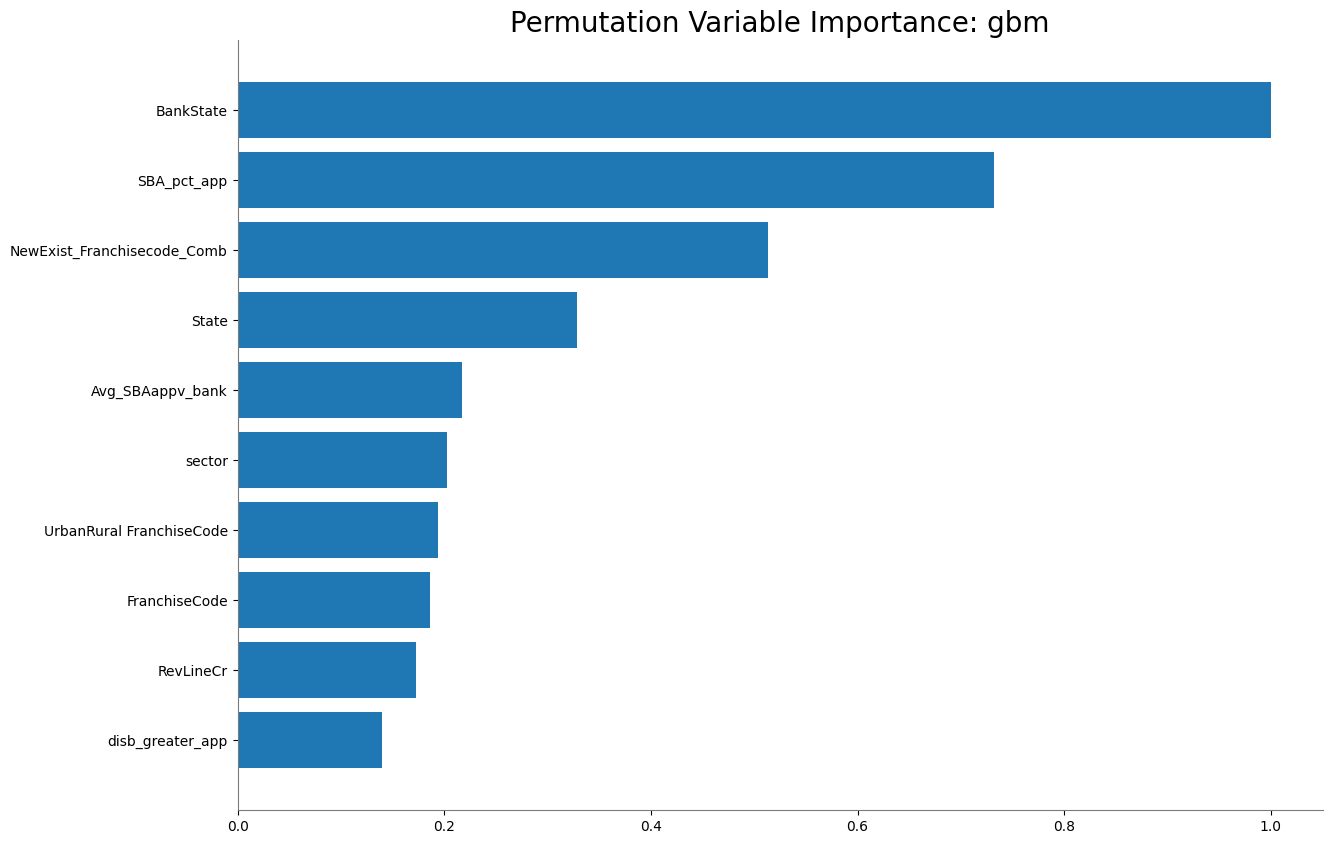

Variable,Relative Importance,Scaled Importance,Percentage
BankState,0.0696406,1.0,0.2293765
SBA_pct_app,0.0510022,0.7323621,0.1679867
NewExist_Franchisecode_Comb,0.0357241,0.5129784,0.1176652
State,0.0228608,0.3282679,0.0752969
Avg_SBAappv_bank,0.0151225,0.2171511,0.0498094
sector,0.0141121,0.2026417,0.0464813
UrbanRural FranchiseCode,0.0135286,0.1942624,0.0445592
FranchiseCode,0.0129388,0.1857943,0.0426169
RevLineCr,0.0120198,0.1725977,0.0395899
disb_greater_app,0.0097278,0.1396863,0.0320408


In [22]:
# Plot of permutation feature importance (bar plot)
best_model_h2o.permutation_importance_plot(test, seed = 42)

The above plot of Permutation feature importance gives us the idea about the most important features contributing in the model prediction. Here in the plot it is seen that the top 5 features that are important are BankState, SBA_pct_app, NewExist_Franchisecode_Comb, State, Avg_SBAappv_bank. Though these features are ranked in importance order, this plot doenot provide us any information regarding the direction of influence in probability. This plot only talks about the important features contributing in the model performance.<br />
For the direction of probability we will plot Shapley values.

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

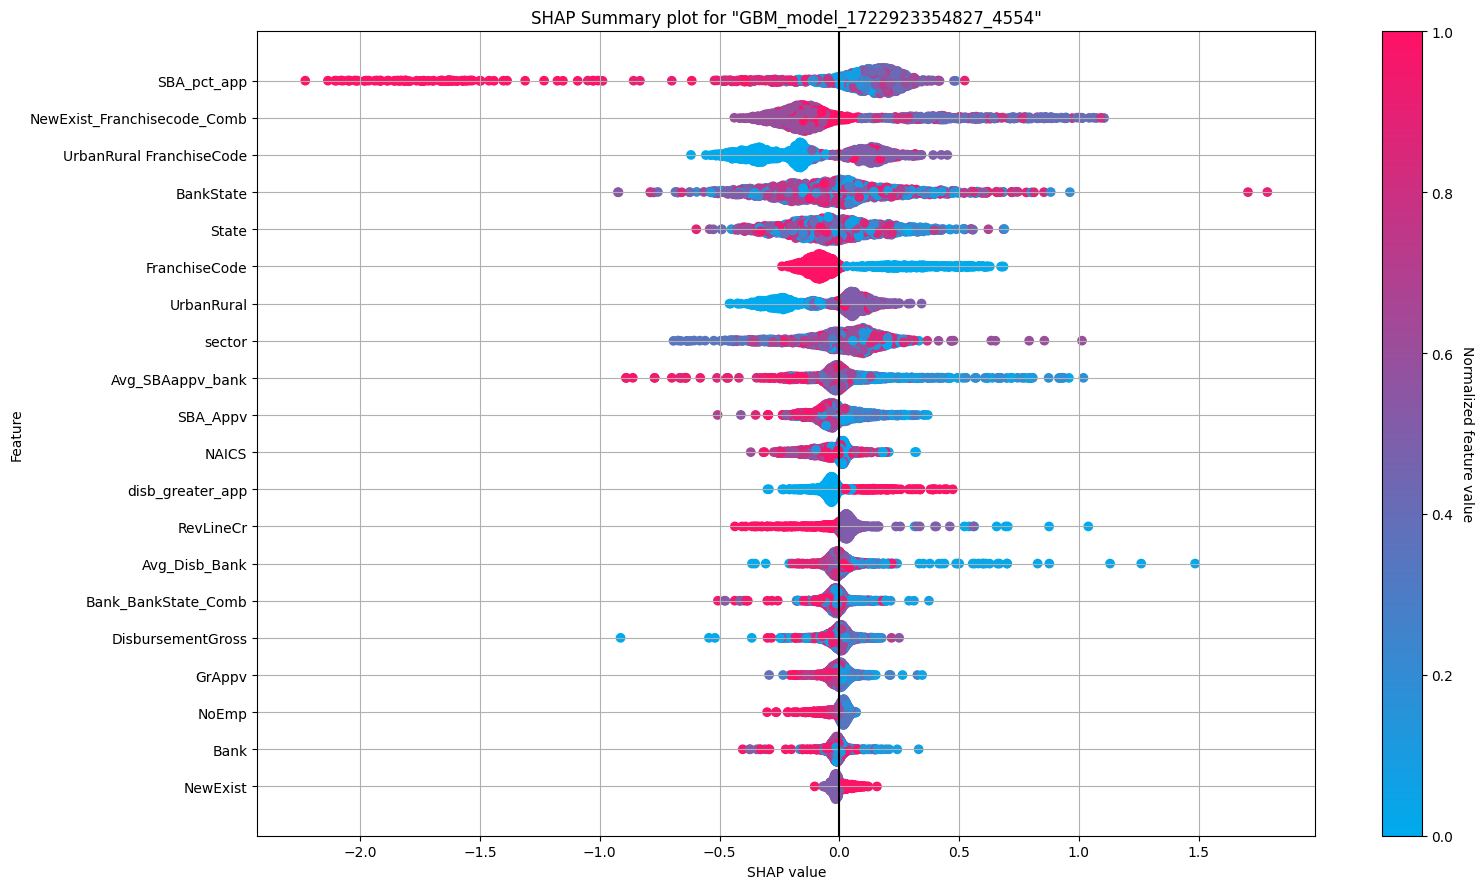

In [23]:
# Shap Summary plot on test data
best_model_h2o.explain(frame=test,include_explanations =['shap_summary']);

**SHAP SUMMARY EXPLANATION**<br />
The above Shap summary plot on test data gives us idea about the most important contributors in predicting the probability of the target column- "MIS_Status". Most importantly this plot gives us idea not only about the feature importance but also about the direction of the probability. As you can see in the plot, the shap values on the left side are negative and that on the right side are positive. Negative shap values bring down the probability of class_1 ('p1'), thus increasing the chance of prediction value as 0. Positive shap values increase the probability of class_1 ('p1'), thus increasing the chance of prediction value of 1.<br />

From the above plot it is evident that the top feature in importance is SBA_pct_app. The red points denote the high values of the feature, implying that high SBA_pct_app have negative shap values, thus contibute in brininging down the probability of class_1 ('p1') and hence increasing the chance of prediction value of 0 (Not_defaulted). This implies that high SBA_pct_app means higher chance of not being defaulted in most of the cases. Similarly, blue points are mostly on the right side with positive shap values implying the low SBA_pct_app contribute in increase the probability of class_1 thus increasing the chance of being defaulted.<br />
The second most important feature NewExist_Franchisecode_Comb have a cluster of shap values on the negative side which contribute in increase in the prediction chance of 0 and there is a range of shap values on the positive side which contribute in increase in the prediction chance of 1.<br />
The third top feature 'UrbanRural FranchiseCode', which is an interaction term. It can be seen that the blue points, with low normalised feature values, have negative shap contributions, increasing the chance of prediction value of 0 (Not_defaulted). A few points with high normalised values and medium normalised values, have positive shap contributions, thus increasing the chance of prediction value of 1 (Defaulted).<br />
State and BankState have a range of shap contributions from negative to positive. But, the exact pattern is not deciphered based on the summary plot.<br />
FranchiseCode - shap plot suggests that having a certain franchiseCode (red points) are clustered, have resulted in negative shap values, contributing to the increase in chance of prediction of 0 and those with blue points are spread out over a range, which contribute in the increase in chance of prediction of target class_1(default).<br />
Features like 'Avg_SBAappv_bank' and 'SBA_Appv' both have most of the red points(high values) on the left side, with negative shap values. This implies that high values  of 'Avg_SBAappv_bank' and 'SBA_Appv' are contributing to the decrease in the prediction probability of class_1, thus increasing the chance of prediction of 0(Not_default). On the other side, the points in blue(low values of SBA_Appv and Avg_SBAappv_bank) contribute in postive shap values, thus pushing up the prediction probability of class_1, and hence increasing the chance of prediction of 1(default).<br />

This way Shap plots help us in understanding about each feature's contribution in the probability of class_1 and further it's prediction value. By plotting the shap plots for individual instance(record) we will have a better idea about the categorical variables like UrbanRural, FranchiseCode, State, BankState, on the pattern of contributions. For example, we can know whether having a FranchiseCode increase or decrease the probability of approval for a particular instance. 

In [24]:
test

City,State,Zip,Bank,BankState,NAICS,NoEmp,NewExist,CreateJob,RetainedJob,RevLineCr,LowDoc,DisbursementGross,GrAppv,SBA_Appv,MIS_Status,sector,pct_job_retained,SBA_pct_app,NewExist_Franchisecode_Comb,Bank_BankState_Comb,Avg_SBAappv_bank,Avg_GrAppv_sector,Avg_GrAppv_State,Avg_Disb_Bank,UrbanRural,UrbanRural FranchiseCode,disb_greater_app,FranchiseCode,disb_greater_app FranchiseCode
East Wilton,ME,4234,"TD BANK, NATIONAL ASSOCIATION",DE,621210,7,1,0,7,N,N,11.9184,11.9197,11.632,0,Health Care and Social Assistance,0,97.5865,1,"TD BANK, NATIONAL ASSOCIATION_DE",11.1103,11.5122,11.1633,11.5413,2,0,0,0,0
REDWAY,CA,9566,NORTH VALLEY BANK,CA,454110,18,1,0,0,N,N,12.9239,12.9239,12.6362,0,Retail Trade,0,97.774,1.01,NORTH VALLEY BANK_CA,11.4636,11.2011,11.6821,11.6588,0,0,0,1,0
CORTLAND,NY,1304,MANUFACTURERS & TRADERS TR CO,NY,0,150,2,0,0,N,N,12.5062,12.5062,12.1351,0,Missing,0,97.033,2.01,MANUFACTURERS & TRADERS TR CO_NY,10.8665,11.8019,11.0906,11.4529,0,0,0,1,0
YONKERS,NY,1070,CAPITAL ONE NATL ASSOC,VA,238190,7,1,0,7,N,N,10.4631,10.4631,9.76996,1,Construction,0,93.3753,1.01,CAPITAL ONE NATL ASSOC_VA,9.98822,11.0177,11.0906,10.7267,1,1,0,1,0
LEAGUE CITY,TX,7757,PEARLAND STATE BANK,TX,0,8,1,0,0,N,Y,11.0821,11.0821,10.8958,0,Missing,0,98.3187,1.01,PEARLAND STATE BANK_TX,10.9408,11.8019,11.499,11.0567,0,0,0,1,0
PEMBERTON,NJ,8068,HOPEWELL VALLEY COMMUNITY BANK,NJ,238320,7,1,0,0,N,Y,11.2252,11.2252,11.0627,0,Construction,0,98.5522,1.01,HOPEWELL VALLEY COMMUNITY BANK_NJ,11.226,11.0177,11.378,11.6459,1,1,0,1,0
TIJERAS,NM,8705,WELLS FARGO BANK NATL ASSOC,SD,624410,11,1,0,0,N,N,11.6742,11.6742,11.3865,1,Health Care and Social Assistance,0,97.5357,1.01,WELLS FARGO BANK NATL ASSOC_SD,11.2498,11.5122,11.479,11.7281,0,0,0,1,0
CAPE CORAL,FL,3399,CAPITAL ONE NATL ASSOC,VA,424210,3,1,0,3,N,N,10.1266,10.1266,9.43348,0,Wholesale Trade,0,93.1552,1.01,CAPITAL ONE NATL ASSOC_VA,9.98822,11.5624,11.2919,10.7267,1,1,0,1,0
FRESNO,CA,9370,FIRST-CITIZENS BK & TR CO,NC,621111,3,1,0,0,N,N,12.8069,13.0677,12.78,0,Health Care and Social Assistance,0,97.7985,1.01,FIRST-CITIZENS BK & TR CO_NC,12.2618,11.5122,11.6821,12.5255,1,1,0,1,0
MAYWOOD,IL,6015,INLAND BANK & TRUST,IL,484121,45,1,0,0,N,N,14.4143,14.4143,13.7982,0,Transportation and Warehousing,0,95.7252,1.01,INLAND BANK & TRUST_IL,11.7922,10.7387,11.2737,12.102,1,1,0,1,0


In [25]:
#Calculate contributions
shapley_contribs = best_model_h2o.predict_contributions(test[0:10,:])
shapley_contribs = test[0:10,:].cbind(shapley_contribs)
shapley_contribs.head()

contributions progress: |████████████████████████████████████████████████████████| (done) 100%


City,State,Zip,Bank,BankState,NAICS,NoEmp,NewExist,CreateJob,RetainedJob,RevLineCr,LowDoc,DisbursementGross,GrAppv,SBA_Appv,MIS_Status,sector,pct_job_retained,SBA_pct_app,NewExist_Franchisecode_Comb,Bank_BankState_Comb,Avg_SBAappv_bank,Avg_GrAppv_sector,Avg_GrAppv_State,Avg_Disb_Bank,UrbanRural,UrbanRural FranchiseCode,disb_greater_app,FranchiseCode,disb_greater_app FranchiseCode,City0,State0,Zip0,Bank0,BankState0,NAICS0,NoEmp0,NewExist0,CreateJob0,RetainedJob0,RevLineCr0,LowDoc0,DisbursementGross0,GrAppv0,SBA_Appv0,sector0,pct_job_retained0,SBA_pct_app0,NewExist_Franchisecode_Comb0,Bank_BankState_Comb0,Avg_SBAappv_bank0,Avg_GrAppv_sector0,Avg_GrAppv_State0,Avg_Disb_Bank0,UrbanRural0,UrbanRural FranchiseCode0,disb_greater_app0,FranchiseCode0,disb_greater_app FranchiseCode0,BiasTerm
East Wilton,ME,4234,"TD BANK, NATIONAL ASSOCIATION",DE,621210,7,1,0,7,N,N,11.9184,11.9197,11.632,0,Health Care and Social Assistance,0,97.5865,1,"TD BANK, NATIONAL ASSOCIATION_DE",11.1103,11.5122,11.1633,11.5413,2,0,0,0,0,0.00384243,-0.448367,-0.0119236,-0.0126484,0.116527,-0.245124,-0.0125668,-0.0155467,-0.00550324,0.0208722,0.029064,-0.00224163,0.00726345,-0.0324582,-0.0458058,-0.653675,-0.00980671,0.195699,0.299066,-0.0313897,-0.117474,-0.00198551,-0.00121031,-0.0479974,0.0352468,-0.156807,-0.0543174,0.182643,-0.0108128,-2.02838
REDWAY,CA,9566,NORTH VALLEY BANK,CA,454110,18,1,0,0,N,N,12.9239,12.9239,12.6362,0,Retail Trade,0,97.774,1.01,NORTH VALLEY BANK_CA,11.4636,11.2011,11.6821,11.6588,0,0,0,1,0,-0.00396055,-0.255591,0.0215135,-0.00990376,0.0538852,-0.0918905,-0.0333433,-0.0436355,-0.0026058,-0.000424424,0.0276758,-0.00719767,-0.028911,-0.0407813,-0.0812552,0.0947492,-0.00316788,0.193345,-0.244504,-0.0229046,-0.02033,-0.000846597,0.00297589,-0.0106726,-0.291509,-0.409345,-0.029642,-0.108906,-0.0170763,-2.02838
CORTLAND,NY,1304,MANUFACTURERS & TRADERS TR CO,NY,0,150,2,0,0,N,N,12.5062,12.5062,12.1351,0,Missing,0,97.033,2.01,MANUFACTURERS & TRADERS TR CO_NY,10.8665,11.8019,11.0906,11.4529,0,0,0,1,0,0.0074537,-0.013082,0.00411447,0.00499363,0.0233502,0.0206197,-0.0842564,0.0848289,-0.00504416,-0.00158718,0.0241267,0.000811423,-0.00170111,-0.00425872,-0.00952809,0.0968527,-0.00410465,0.118325,-0.088667,-0.00993294,0.0038811,0.00180326,-0.000464361,-0.0109995,-0.197169,-0.255712,-0.0223235,-0.120972,-0.0107718,-2.02838
YONKERS,NY,1070,CAPITAL ONE NATL ASSOC,VA,238190,7,1,0,7,N,N,10.4631,10.4631,9.76996,1,Construction,0,93.3753,1.01,CAPITAL ONE NATL ASSOC_VA,9.98822,11.0177,11.0906,10.7267,1,1,0,1,0,-0.0257754,0.036153,-0.0296229,-0.0398752,0.600405,-0.0583733,-0.0136477,-0.00391918,-0.00502715,0.0220909,0.0403895,0.00328831,0.0174713,0.024474,0.000896757,0.0601872,-0.00327591,0.113582,-0.209814,-0.0573021,0.0554485,0.00139349,0.00215109,-0.00928467,0.146488,0.25755,-0.106073,-0.114472,-0.0618169,-2.02838
LEAGUE CITY,TX,7757,PEARLAND STATE BANK,TX,0,8,1,0,0,N,Y,11.0821,11.0821,10.8958,0,Missing,0,98.3187,1.01,PEARLAND STATE BANK_TX,10.9408,11.8019,11.499,11.0567,0,0,0,1,0,0.0133843,0.0597374,-0.00445303,0.00991273,0.151966,0.0186324,0.00593148,-0.0301551,-0.00354805,-0.00168048,0.0229118,-0.00496988,0.013098,0.00629453,-0.00688534,0.103595,-0.00443877,0.0663204,-0.347572,0.00473003,-0.0127436,0.00180376,-0.000221622,0.00586483,-0.309423,-0.401025,-0.0239495,-0.176377,-0.0128915,-2.02838
PEMBERTON,NJ,8068,HOPEWELL VALLEY COMMUNITY BANK,NJ,238320,7,1,0,0,N,Y,11.2252,11.2252,11.0627,0,Construction,0,98.5522,1.01,HOPEWELL VALLEY COMMUNITY BANK_NJ,11.226,11.0177,11.378,11.6459,1,1,0,1,0,-0.00579001,-0.138772,-0.0172081,0.0125643,-0.283932,-0.0174276,0.00630319,-0.00724799,-0.00368041,-0.000842788,0.0231033,-0.0219077,0.0342344,0.0292674,-0.0203836,0.0793616,-0.00317758,0.170884,-0.115733,0.0117788,-0.0193066,-0.00125411,-0.00184997,-0.0112691,0.0943848,0.146848,-0.0292977,-0.0699411,-0.0255102,-2.02838
TIJERAS,NM,8705,WELLS FARGO BANK NATL ASSOC,SD,624410,11,1,0,0,N,N,11.6742,11.6742,11.3865,1,Health Care and Social Assistance,0,97.5357,1.01,WELLS FARGO BA

From the Above Shap Contributions dataframe, we get to know that the 'BiasTerm' or the base value is appx -2.03.

In [26]:
test_predict = best_model_h2o.predict(test)
test_predict = test_predict.cbind(test)
test_predict

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


predict,p0,p1,City,State,Zip,Bank,BankState,NAICS,NoEmp,NewExist,CreateJob,RetainedJob,RevLineCr,LowDoc,DisbursementGross,GrAppv,SBA_Appv,MIS_Status,sector,pct_job_retained,SBA_pct_app,NewExist_Franchisecode_Comb,Bank_BankState_Comb,Avg_SBAappv_bank,Avg_GrAppv_sector,Avg_GrAppv_State,Avg_Disb_Bank,UrbanRural,UrbanRural FranchiseCode,disb_greater_app,FranchiseCode,disb_greater_app FranchiseCode
0,0.955035,0.0449654,East Wilton,ME,4234,"TD BANK, NATIONAL ASSOCIATION",DE,621210,7,1,0,7,N,N,11.9184,11.9197,11.632,0,Health Care and Social Assistance,0,97.5865,1,"TD BANK, NATIONAL ASSOCIATION_DE",11.1103,11.5122,11.1633,11.5413,2,0,0,0,0
0,0.967474,0.0325264,REDWAY,CA,9566,NORTH VALLEY BANK,CA,454110,18,1,0,0,N,N,12.9239,12.9239,12.6362,0,Retail Trade,0,97.774,1.01,NORTH VALLEY BANK_CA,11.4636,11.2011,11.6821,11.6588,0,0,0,1,0
0,0.92257,0.0774301,CORTLAND,NY,1304,MANUFACTURERS & TRADERS TR CO,NY,0,150,2,0,0,N,N,12.5062,12.5062,12.1351,0,Missing,0,97.033,2.01,MANUFACTURERS & TRADERS TR CO_NY,10.8665,11.8019,11.0906,11.4529,0,0,0,1,0
0,0.799739,0.200261,YONKERS,NY,1070,CAPITAL ONE NATL ASSOC,VA,238190,7,1,0,7,N,N,10.4631,10.4631,9.76996,1,Construction,0,93.3753,1.01,CAPITAL ONE NATL ASSOC_VA,9.98822,11.0177,11.0906,10.7267,1,1,0,1,0
0,0.947075,0.0529253,LEAGUE CITY,TX,7757,PEARLAND STATE BANK,TX,0,8,1,0,0,N,Y,11.0821,11.0821,10.8958,0,Missing,0,98.3187,1.01,PEARLAND STATE BANK_TX,10.9408,11.8019,11.499,11.0567,0,0,0,1,0
0,0.901516,0.0984835,PEMBERTON,NJ,8068,HOPEWELL VALLEY COMMUNITY BANK,NJ,238320,7,1,0,0,N,Y,11.2252,11.2252,11.0627,0,Construction,0,98.5522,1.01,HOPEWELL VALLEY COMMUNITY BANK_NJ,11.226,11.0177,11.378,11.6459,1,1,0,1,0
0,0.926277,0.073723,TIJERAS,NM,8705,WELLS FARGO BANK NATL ASSOC,SD,624410,11,1,0,0,N,N,11.6742,11.6742,11.3865,1,Health Care and Social Assistance,0,97.5357,1.01,WELLS FARGO BANK NATL ASSOC_SD,11.2498,11.5122,11.479,11.7281,0,0,0,1,0
1,0.691868,0.308132,CAPE CORAL,FL,3399,CAPITAL ONE NATL ASSOC,VA,424210,3,1,0,3,N,N,10.1266,10.1266,9.43348,0,Wholesale Trade,0,93.1552,1.01,CAPITAL ONE NATL ASSOC_VA,9.98822,11.5624,11.2919,10.7267,1,1,0,1,0
0,0.945981,0.0540195,FRESNO,CA,9370,FIRST-CITIZENS BK & TR CO,NC,621111,3,1,0,0,N,N,12.8069,13.0677,12.78,0,Health Care and Social Assistance,0,97.7985,1.01,FIRST-CITIZENS BK & TR CO_NC,12.2618,11.5122,11.6821,12.5255,1,1,0,1,0
0,0.830163,0.169837,MAYWOOD,IL,6015,INLAND BANK & TRUST,IL,484121,45,1,0,0,N,N,14.4143,14.4143,13.7982,0,Transportation and Warehousing,0,95.7252,1.01,INLAND BANK & TRUST_IL,11.7922,10.7387,11.2737,12.102,1,1,0,1,0


In [27]:
row_num_frame = h2o.H2OFrame.from_python(list(range(test_predict.nrow)), column_names=["row_index"])
# Combine the row numbers with the original data
test_predict_with_rows = test_predict.cbind(row_num_frame)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [28]:
test_predict_with_rows

predict,p0,p1,City,State,Zip,Bank,BankState,NAICS,NoEmp,NewExist,CreateJob,RetainedJob,RevLineCr,LowDoc,DisbursementGross,GrAppv,SBA_Appv,MIS_Status,sector,pct_job_retained,SBA_pct_app,NewExist_Franchisecode_Comb,Bank_BankState_Comb,Avg_SBAappv_bank,Avg_GrAppv_sector,Avg_GrAppv_State,Avg_Disb_Bank,UrbanRural,UrbanRural FranchiseCode,disb_greater_app,FranchiseCode,disb_greater_app FranchiseCode,row_index
0,0.955035,0.0449654,East Wilton,ME,4234,"TD BANK, NATIONAL ASSOCIATION",DE,621210,7,1,0,7,N,N,11.9184,11.9197,11.632,0,Health Care and Social Assistance,0,97.5865,1,"TD BANK, NATIONAL ASSOCIATION_DE",11.1103,11.5122,11.1633,11.5413,2,0,0,0,0,0
0,0.967474,0.0325264,REDWAY,CA,9566,NORTH VALLEY BANK,CA,454110,18,1,0,0,N,N,12.9239,12.9239,12.6362,0,Retail Trade,0,97.774,1.01,NORTH VALLEY BANK_CA,11.4636,11.2011,11.6821,11.6588,0,0,0,1,0,1
0,0.92257,0.0774301,CORTLAND,NY,1304,MANUFACTURERS & TRADERS TR CO,NY,0,150,2,0,0,N,N,12.5062,12.5062,12.1351,0,Missing,0,97.033,2.01,MANUFACTURERS & TRADERS TR CO_NY,10.8665,11.8019,11.0906,11.4529,0,0,0,1,0,2
0,0.799739,0.200261,YONKERS,NY,1070,CAPITAL ONE NATL ASSOC,VA,238190,7,1,0,7,N,N,10.4631,10.4631,9.76996,1,Construction,0,93.3753,1.01,CAPITAL ONE NATL ASSOC_VA,9.98822,11.0177,11.0906,10.7267,1,1,0,1,0,3
0,0.947075,0.0529253,LEAGUE CITY,TX,7757,PEARLAND STATE BANK,TX,0,8,1,0,0,N,Y,11.0821,11.0821,10.8958,0,Missing,0,98.3187,1.01,PEARLAND STATE BANK_TX,10.9408,11.8019,11.499,11.0567,0,0,0,1,0,4
0,0.901516,0.0984835,PEMBERTON,NJ,8068,HOPEWELL VALLEY COMMUNITY BANK,NJ,238320,7,1,0,0,N,Y,11.2252,11.2252,11.0627,0,Construction,0,98.5522,1.01,HOPEWELL VALLEY COMMUNITY BANK_NJ,11.226,11.0177,11.378,11.6459,1,1,0,1,0,5
0,0.926277,0.073723,TIJERAS,NM,8705,WELLS FARGO BANK NATL ASSOC,SD,624410,11,1,0,0,N,N,11.6742,11.6742,11.3865,1,Health Care and Social Assistance,0,97.5357,1.01,WELLS FARGO BANK NATL ASSOC_SD,11.2498,11.5122,11.479,11.7281,0,0,0,1,0,6
1,0.691868,0.308132,CAPE CORAL,FL,3399,CAPITAL ONE NATL ASSOC,VA,424210,3,1,0,3,N,N,10.1266,10.1266,9.43348,0,Wholesale Trade,0,93.1552,1.01,CAPITAL ONE NATL ASSOC_VA,9.98822,11.5624,11.2919,10.7267,1,1,0,1,0,7
0,0.945981,0.0540195,FRESNO,CA,9370,FIRST-CITIZENS BK & TR CO,NC,621111,3,1,0,0,N,N,12.8069,13.0677,12.78,0,Health Care and Social Assistance,0,97.7985,1.01,FIRST-CITIZENS BK & TR CO_NC,12.2618,11.5122,11.6821,12.5255,1,1,0,1,0,8
0,0.830163,0.169837,MAYWOOD,IL,6015,INLAND BANK & TRUST,IL,484121,45,1,0,0,N,N,14.4143,14.4143,13.7982,0,Transportation and Warehousing,0,95.7252,1.01,INLAND BANK & TRUST_IL,11.7922,10.7387,11.2737,12.102,1,1,0,1,0,9


In [29]:
condition1 = (test_predict_with_rows['MIS_Status'] == '1') & (test_predict_with_rows['predict'] == '1')
cols1 = test_predict_with_rows[condition1,:]
cols1.sort(by='p1', ascending=False)

predict,p0,p1,City,State,Zip,Bank,BankState,NAICS,NoEmp,NewExist,CreateJob,RetainedJob,RevLineCr,LowDoc,DisbursementGross,GrAppv,SBA_Appv,MIS_Status,sector,pct_job_retained,SBA_pct_app,NewExist_Franchisecode_Comb,Bank_BankState_Comb,Avg_SBAappv_bank,Avg_GrAppv_sector,Avg_GrAppv_State,Avg_Disb_Bank,UrbanRural,UrbanRural FranchiseCode,disb_greater_app,FranchiseCode,disb_greater_app FranchiseCode,row_index
1,0.047444,0.952556,BROOKLYN,NY,1120,HSBC BK USA NATL ASSOC,VA,424480,2,2,0,2,Y,N,11.8538,11.5129,10.8198,1,Wholesale Trade,0,93.9794,2,HSBC BK USA NATL ASSOC_VA,10.5648,11.5624,11.0906,11.2474,1,0,1,0,0,142967
1,0.0506878,0.949312,NEW YORK,NY,1003,HSBC BK USA NATL ASSOC,VA,531390,3,1,0,3,Y,N,12.2259,11.5129,10.8198,1,Real Estate and Rental and Leasing,0,93.9794,1.01,HSBC BK USA NATL ASSOC_VA,10.5648,11.0664,11.0906,11.2474,1,1,1,1,1,23092
1,0.050691,0.949309,BROOKLYN,NY,1121,HSBC BK USA NATL ASSOC,VA,448210,1,2,4,4,Y,N,10.6882,10.1266,9.43348,1,Retail Trade,100,93.1552,2,HSBC BK USA NATL ASSOC_VA,10.5648,11.2011,11.0906,11.2474,1,0,1,0,0,36139
1,0.0507058,0.949294,JAMESPORT,NY,1194,HSBC BK USA NATL ASSOC,VA,448150,2,2,0,2,Y,N,10.4823,10.1266,9.43348,1,Retail Trade,0,93.1552,2,HSBC BK USA NATL ASSOC_VA,10.5648,11.2011,11.0906,11.2474,1,0,1,0,0,101323
1,0.0518506,0.948149,ANCHORAGE,AK,9951,FDIC/SNB,CA,0,35,1,0,0,N,N,13.2177,13.2177,13.1123,1,Missing,0,99.2029,1,FDIC/SNB_CA,12.6971,11.8019,11.7045,12.804,0,0,0,0,0,45442
1,0.0524787,0.947521,NEW YORK,NY,1001,HSBC BK USA NATL ASSOC,VA,532230,2,2,1,2,Y,N,11.0233,10.1266,9.43348,1,Real Estate and Rental and Leasing,200,93.1552,2,HSBC BK USA NATL ASSOC_VA,10.5648,11.0664,11.0906,11.2474,1,0,1,0,0,90113
1,0.0528386,0.947161,GOSHEN,NY,1092,HSBC BK USA NATL ASSOC,VA,337129,4,1,0,4,Y,N,11.5129,11.5129,10.8198,1,Manufacturing,0,93.9794,1,HSBC BK USA NATL ASSOC_VA,10.5648,11.6916,11.0906,11.2474,1,0,0,0,0,47976
1,0.053037,0.946963,FLUSHING,NY,1135,HSBC BK USA NATL ASSOC,VA,325620,3,1,0,3,Y,N,10.6792,10.1266,9.43348,1,Manufacturing,0,93.1552,1,HSBC BK USA NATL ASSOC_VA,10.5648,11.6916,11.0906,11.2474,2,0,1,0,0,30514
1,0.0544495,0.94555,BROOKLYN,NY,1122,HSBC BK USA NATL ASSOC,VA,522310,3,2,0,3,Y,N,11.1563,10.8198,10.1266,1,Finance and Insurance,0,93.5937,2,HSBC BK USA NATL ASSOC_VA,10.5648,10.8983,11.0906,11.2474,1,0,1,0,0,34730
1,0.0544921,0.945508,SUNNYSIDE,NY,1110,HSBC BK USA NATL ASSOC,VA,452990,6,1,0,6,Y,N,11.5179,11.5129,10.8198,1,Retail Trade,0,93.9794,1.01,HSBC BK USA NATL ASSOC_VA,10.5648,11.2011,11.0906,11.2474,1,1,1,1,1,14333


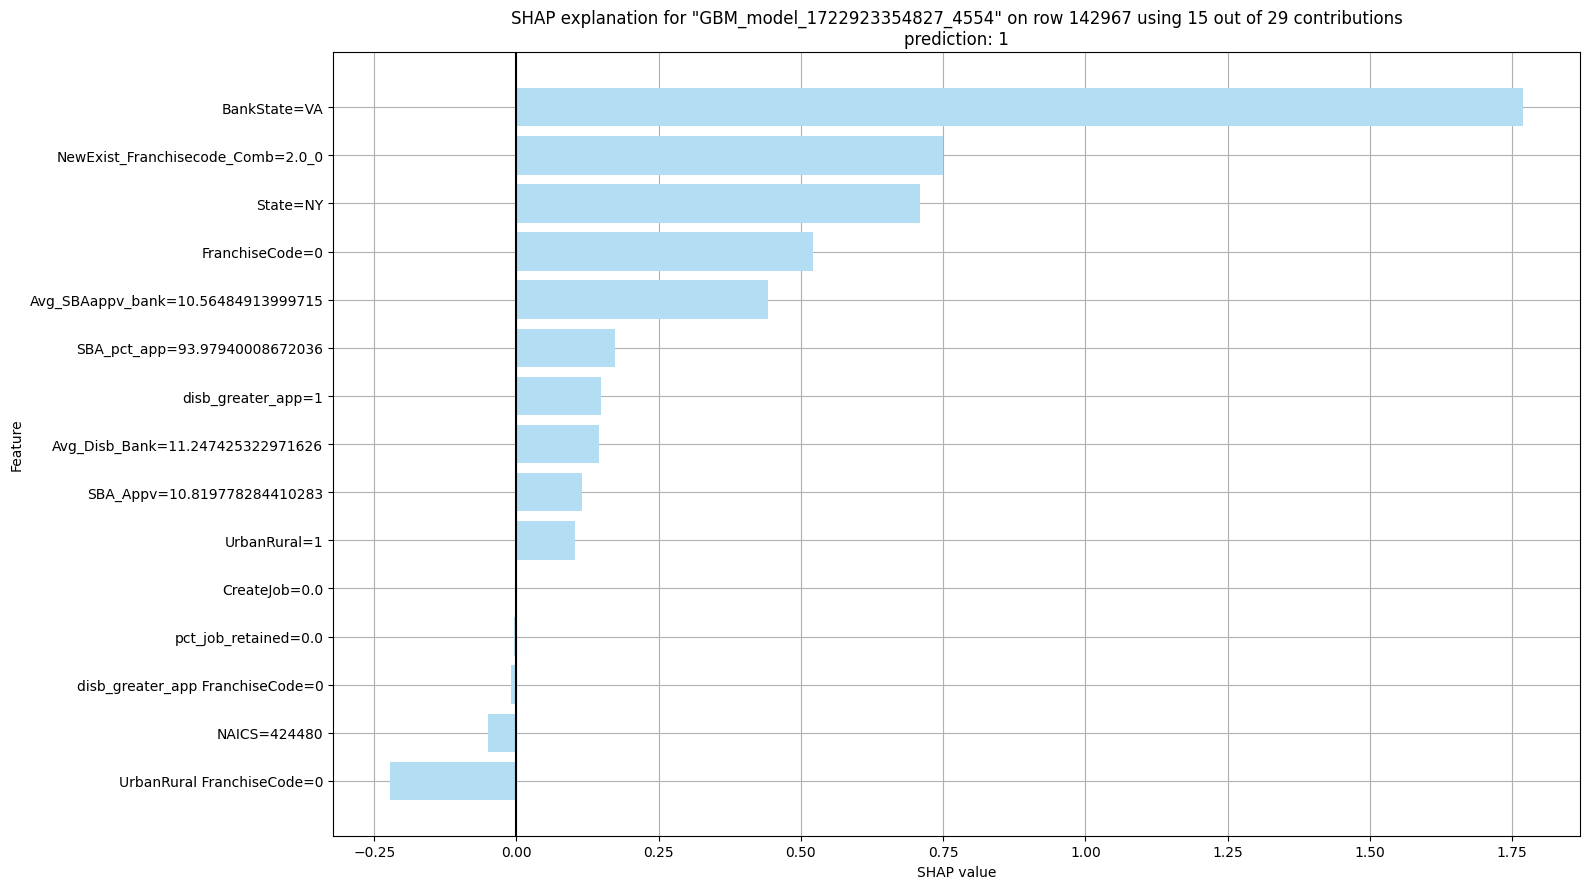

In [30]:
# 'MIS_Status' = 1, 'predict' = 1
best_model_h2o.shap_explain_row_plot(test_predict, row_index=142967)

**Case 1:'MIS_Status' = 1, 'predict' = 1**<br />
For this record of row_index = 142967, it is seen that the actual value 'MIS_Status' = 1 and the predicted 'MIS_Status' = 1. The 'p1' probability for this case = 0.952556, which is way more than the threshold value of  0.22954. This implies that this model predicts the target class **accurately with significant probabilty**. This means we can strongly say that the predicted class is **highly correct** as the predicted probability is much higher than the threshold value, implying that the residual value for this case is nearly 0.<br />
In the record, by plotting the shap plot, we can say that feature 'BankState' has highest contribution of more than +1.75, followed by 'NewExist_Franchise_Comb'(+0.75), State (a little less than +0.75). We can see that, BankState = VA, NewExist_Franchise_Comb - Combination of New_Business and No FranchiseCode, State = NY are contributing positively and hence increasing the probability of p1, i.e. the chance of getting defaulted. From, the Shap plot it is clear that most of the features are having positive shap values, thus contributing to higher probability of p1. Only, three features are seen having negative shap values and therefore their impact is negligible. Since, most of the features(10 in the plot) are having highly positive shap values compared to very less features of negative shap values(3 in the plot), with less contribution, the additive of all these shap values to the 'biasterm'= -2.03 results in positive value, which followed by the logit conversion is resulting in an high 'p1' of 0.952556 and thus prediction of 1.<br />
For this case the best_model_h2o has made significantly correct prediction.

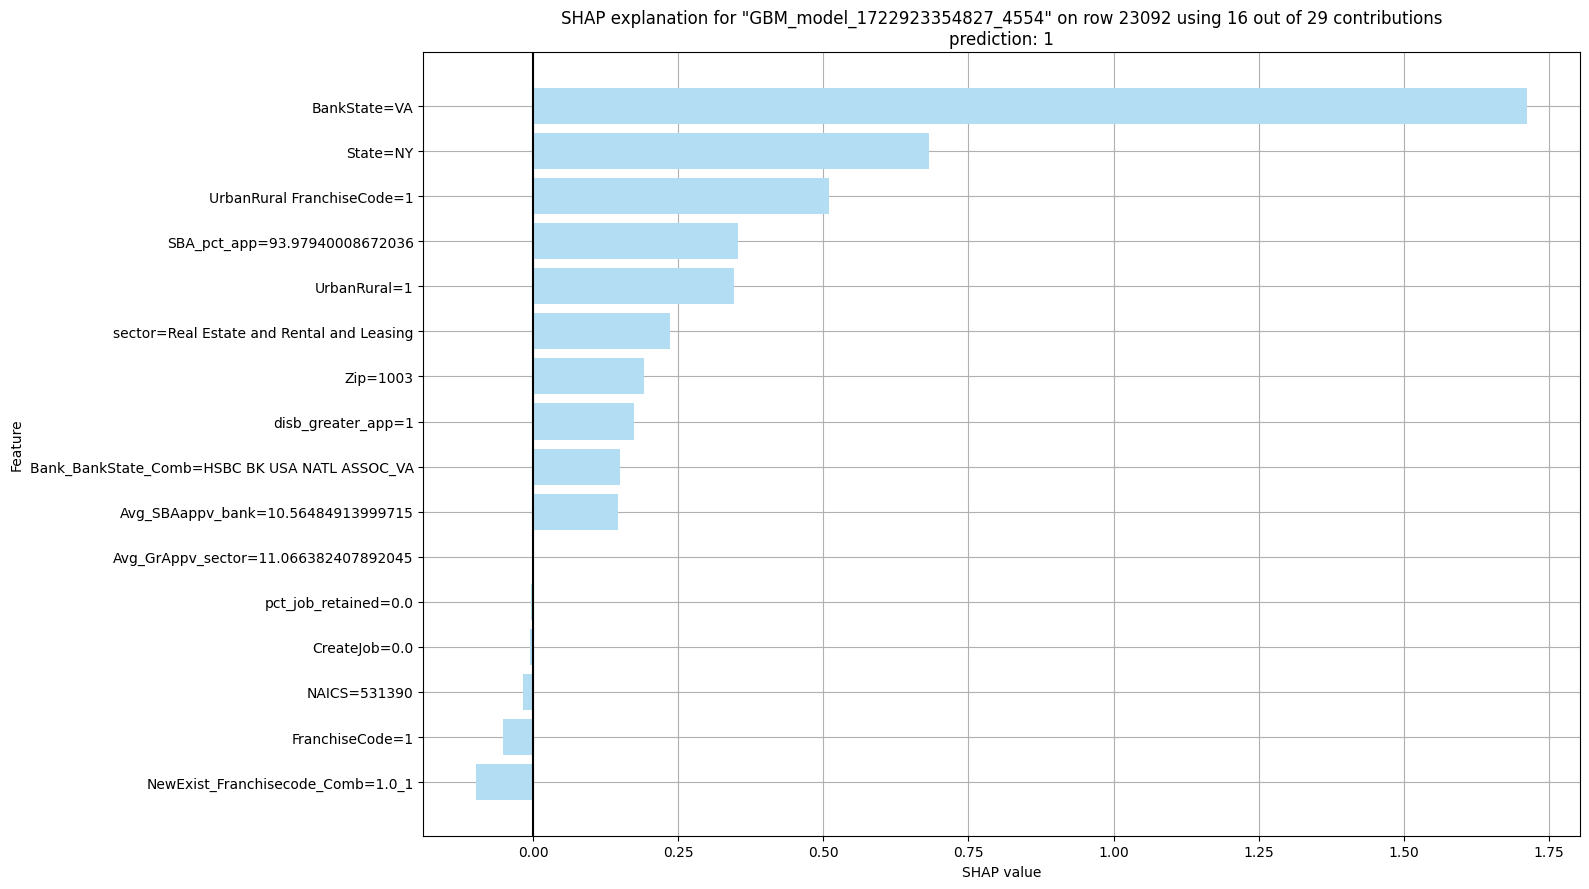

In [31]:
# 'MIS_Status' = 1, 'predict' = 1
best_model_h2o.shap_explain_row_plot(test_predict, row_index=23092)

**Case 1:'MIS_Status' = 1, 'predict' = 1**<br />
For this record of row_index = 23092, it is seen that the actual value 'MIS_Status' = 1 and the predicted 'MIS_Status' = 1. The 'p1' probability for this case = 0.949312, which is way more than the threshold value of 0.22954. This implies that this model predicts the target class **accurately with significant probabilty**. This means we can strongly say that the predicted class is **highly correct** as the predicted probability is much higher than the threshold value, implying that the residual value for this case is nearly 0.<br />
In this case, top most important feature is BankState with appx. +1.75 shap value followed by 'State' with appx. +0.75, 'UrbanRural FranchiseCode' (+0.50). We can see that, BankState = VA, State = NY, UrbanRural FranchiseCode = 1 (Urban with Franchise code) are contributing positively and hence increasing the probability of p1, i.e. the chance of getting defaulted. From, the Shap plot it is clear that most of the features are having positive shap values, thus contributing to higher probability of p1. Only, four features are seen having very less negative shap values and therefore their impact is negligible. Since, most of the features(10 in the plot) are having positive shap values compared to very less features of negative shap values (4 in the plot), with less contribution, the additive of all these shap values to the 'biasterm' of -2.03 results in positive value, which followed by the logit conversion is resulting in an high 'p1' of 0.949312 and thus prediction of 1.<br />
For this case the best_model_h2o has made significantly correct prediction.

In [32]:
condition2 = (test_predict_with_rows['MIS_Status'] == '1') & (test_predict_with_rows['predict'] == '0')
cols2 = test_predict_with_rows[condition2,:]
cols2.sort(by='p1', ascending=True)

predict,p0,p1,City,State,Zip,Bank,BankState,NAICS,NoEmp,NewExist,CreateJob,RetainedJob,RevLineCr,LowDoc,DisbursementGross,GrAppv,SBA_Appv,MIS_Status,sector,pct_job_retained,SBA_pct_app,NewExist_Franchisecode_Comb,Bank_BankState_Comb,Avg_SBAappv_bank,Avg_GrAppv_sector,Avg_GrAppv_State,Avg_Disb_Bank,UrbanRural,UrbanRural FranchiseCode,disb_greater_app,FranchiseCode,disb_greater_app FranchiseCode,row_index
0,0.988721,0.0112786,OKLAHOMA CITY,OK,7311,NBANC,OK,924110,1,1,0,0,N,Y,10.7608,11.1377,11.0324,1,Public Administration,0,99.0541,1.01,NBANC_OK,10.965,10.8788,11.4422,11.1775,0,0,0,1,0,152119
0,0.987989,0.0120112,OAK PARK HEIGHTS,MN,5508,LAKE ELMO BANK,MN,336992,500,1,0,0,Y,N,14.221,14.221,14.1156,1,Manufacturing,0,99.2591,1.01,LAKE ELMO BANK_MN,11.3235,11.6916,11.545,11.7352,1,1,0,1,0,71538
0,0.987769,0.0122309,Montclair (township of),NJ,7043,THE PROVIDENT BANK,NJ,445299,20,2,0,20,N,N,13.6762,13.7851,13.6797,1,Retail Trade,0,99.2357,2.01,THE PROVIDENT BANK_NJ,11.6706,11.2011,11.378,12.0828,1,1,0,1,0,7387
0,0.987001,0.012999,MONTICELLO,KY,4263,GERMAN AMER BANCORP D/B/A GERM,IN,112320,2,2,0,0,N,N,12.7441,12.7455,12.583,1,"Agriculture, Forestry, Fishing and Hunting",0,98.7249,2.01,GERMAN AMER BANCORP D/B/A GERM_IN,11.9352,11.8042,11.2793,12.1267,0,0,0,1,0,109359
0,0.98623,0.0137698,SEATTLE,WA,9810,WELLS FARGO BANK NATL ASSOC,SD,339911,7,1,0,0,N,N,11.5129,11.5129,11.4076,1,Manufacturing,0,99.0849,1.01,WELLS FARGO BANK NATL ASSOC_SD,11.2498,11.6916,11.4177,11.7281,0,0,0,1,0,49760
0,0.985859,0.0141414,ANNANDALE,VA,2200,UNITED BANK,VA,541921,1,1,0,0,N,Y,10.2805,10.9569,10.8516,1,"Professional, Scientific, and Technical Services",0,99.0384,1.01,UNITED BANK_VA,11.1639,10.9699,11.3212,11.4434,0,0,0,1,0,1246
0,0.984869,0.0151312,WHITE PIGEON,MI,4909,MUTUALBANK,IN,336214,68,1,0,0,Y,N,13.7902,13.7902,13.6848,1,Manufacturing,0,99.236,1.01,MUTUALBANK_IN,11.9898,11.6916,11.3813,12.227,2,2,0,1,0,128892
0,0.98466,0.0153404,HARAHAN,LA,7012,WHITNEY BANK,MS,0,3,1,0,0,N,Y,11.2645,11.2645,11.1366,1,Missing,0,98.8652,1.01,WHITNEY BANK_MS,11.2631,11.8019,11.2267,11.5034,0,0,0,1,0,4237
0,0.984455,0.0155446,KEENE,NH,3431,"TD BANK, NATIONAL ASSOCIATION",NH,541110,1,2,0,0,N,Y,10.4631,10.4631,10.3577,1,"Professional, Scientific, and Technical Services",0,98.993,2.01,"TD BANK, NATIONAL ASSOCIATION_NH",11.1103,10.9699,11.0071,11.5413,0,0,0,1,0,130426
0,0.983869,0.0161311,RENTON,WA,9805,BANK OF AMERICA NATL ASSOC,NC,453210,20,1,0,0,N,N,13.5924,13.5924,13.4298,1,Retail Trade,0,98.8043,1.01,BANK OF AMERICA NATL ASSOC_NC,9.88776,11.2011,11.4177,10.6855,0,0,0,1,0,145663


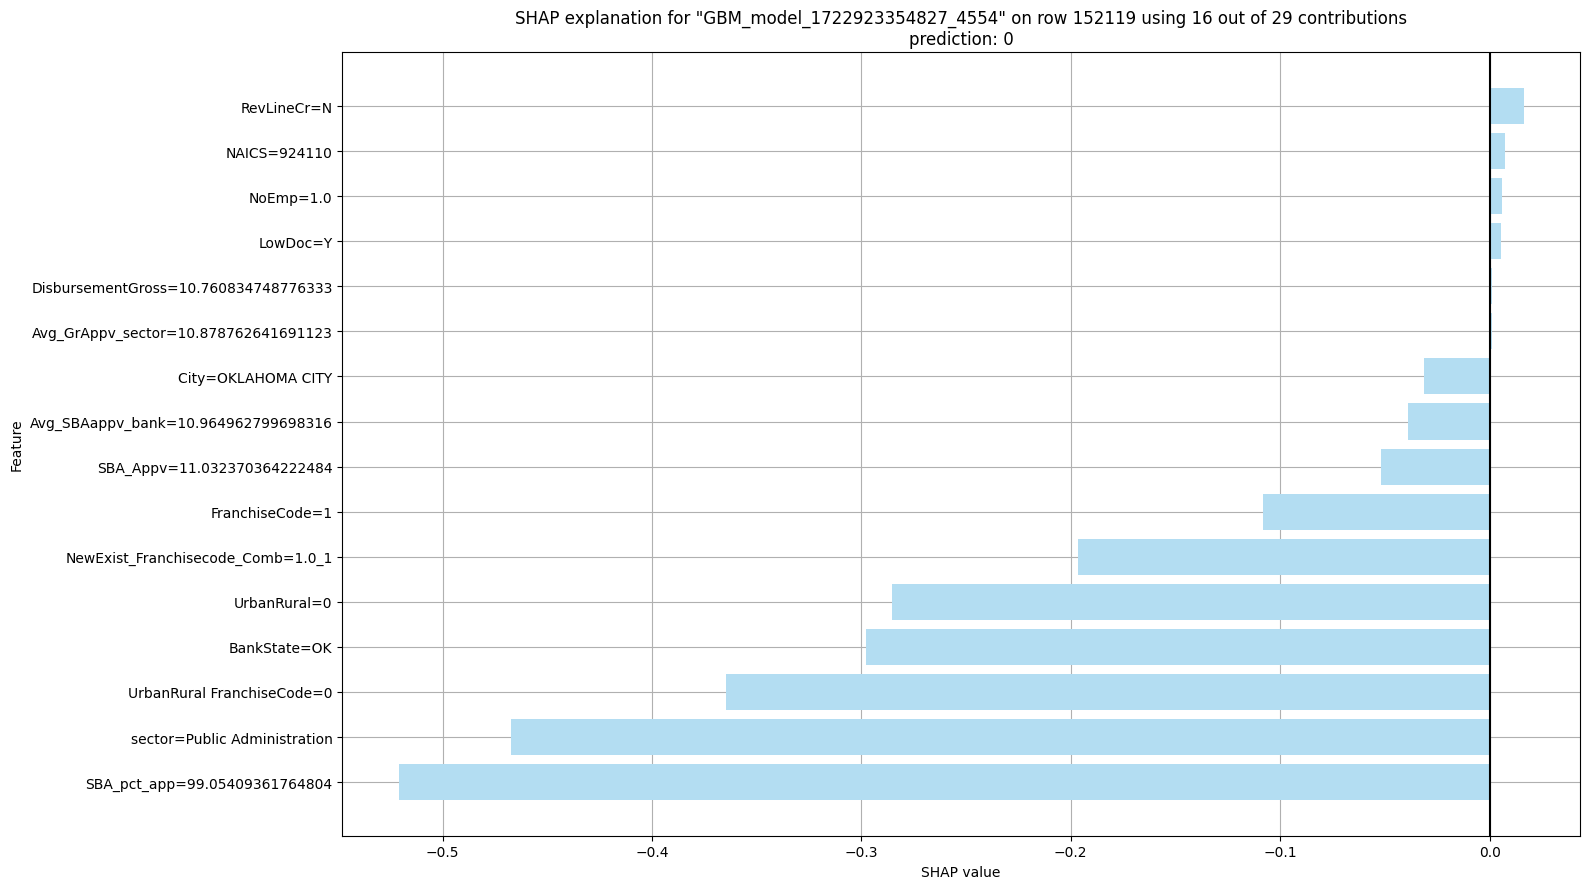

In [33]:
# 'MIS_Status' = 1, 'predict' = 0
best_model_h2o.shap_explain_row_plot(test_predict, row_index=152119)

**Case 2:'MIS_Status' = 1, 'predict' = 0**<br />
For this record of row_index = 152119, it is seen that the actual value 'MIS_Status' = 1 and the predicted 'MIS_Status' = 0. The 'p1' probability for this case = 0.0112786, which is quite less than the threshold value of  0.22954. This implies that this model predicts the target class **inaccurately with significant probabilty**. This means we can strongly say that the predicted class is **highly incorrect** as the predicted probability is much lower than the threshold value, implying that the residual value for this case is highly positive(2.99494).<br />
In this case, top most important feature is SBA_pct_aap with appx. -0.5 shap value followed by 'sector' with shap value appx. -0.45, 'UrbanRural FranchiseCode' (shap value appx. -0.35). We can see that, sector = Public Administration, State = NY, UrbanRural FranchiseCode = 0 (Rural with FranchiseCode) are contributing negatively and hence decreasing the probability of p1, i.e. the chance of not getting defaulted. From, the Shap plot it is clear that most of the features are having negative shap values, thus contributing to a very low probability of p1. Only, four features are seen having positive shap values that too very less and therefore their impact is negligible. Since, most of the features(10 in the plot) are having negative shap values compared to very less features of positive shap values(4 in the plot), with less contribution, the additive of all these shap values to the 'biasterm' of -2.03 results in more negative value,which followed by the logit conversion is resulting in a very low 'p1' of 0.0112786 and thus prediction of 0.<br />
For this case the best_model_h2o has made significantly incorrect prediction.

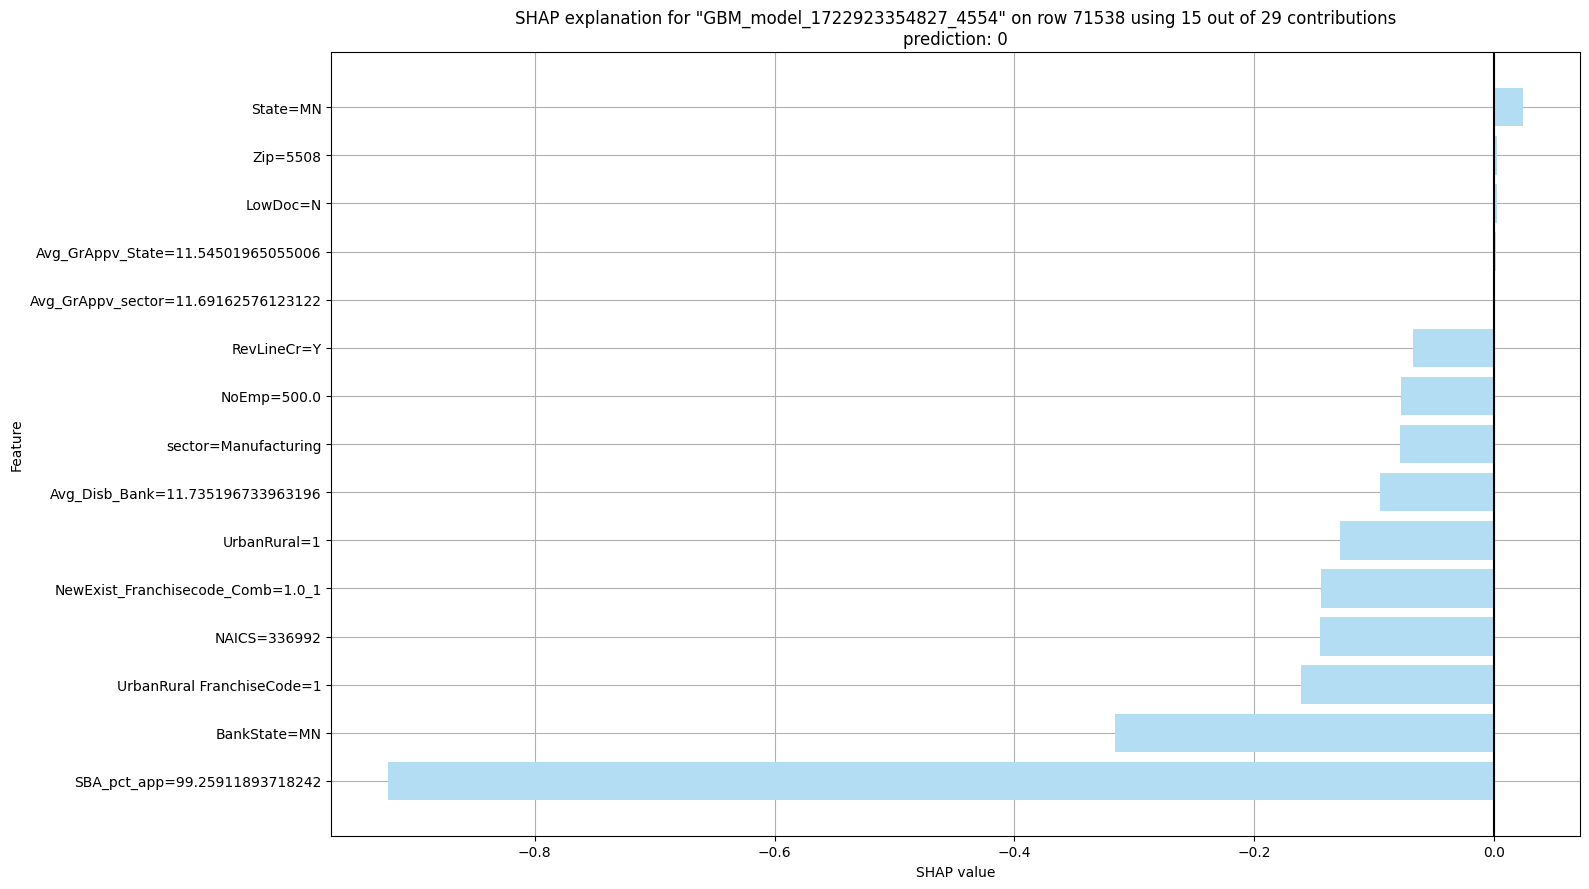

In [34]:
# 'MIS_Status' = 1, 'predict' = 0
best_model_h2o.shap_explain_row_plot(test_predict, row_index=71538)

**Case 2:'MIS_Status' = 1, 'predict' = 0**<br />
For this record of row_index = 71538, it is seen that the actual value 'MIS_Status' = 1 and the predicted 'MIS_Status' = 0. The 'p1' probability for this case = 0.0120112, which is quite less than the threshold value of  0.22954. This implies that this model predicts the target class **inaccurately with significant probabilty**. This means we can strongly say that the predicted class is **highly incorrect** as the predicted probability is much lower than the threshold value, implying that the residual value for this case is highly positive (2.97386).<br />
In this case, top most important feature is SBA_pct_aap with appx. -0.95 shap value followed by 'BankState' with shap value appx. -0.3, 'UrbanRural FranchiseCode' (shap value appx. -0.2). We can see that, BankState = MN, UrbanRural FranchiseCode = 1 (Urban and having franchise code) are contributing negatively and hence decreasing the probability of p1, i.e. the chance of not getting defaulted. From, the Shap plot it is clear that most of the features are having negative shap values, thus contributing to a very low probability of p1. Only, 3 features (2 are negligible) are seen having a positive shap values and therefore their impact is very less. Since, most of the features(10 in the plot) are having negative shap values compared to very less features of positive shap values(3 in the plot), with very less contribution, the additive of all these shap values to the 'biasterm' of -2.03 results in more negative value, which followed by the logit conversion is resulting in a very low 'p1' of 0.0120112 and thus prediction of 0.<br />
For this case the best_model_h2o has made significantly incorrect prediction.<br />

In [35]:
condition3 = (test_predict_with_rows['MIS_Status'] == '0') & (test_predict_with_rows['predict'] == '0')
cols3 = test_predict_with_rows[condition3,:]
cols3.sort(by='p1', ascending=True)

predict,p0,p1,City,State,Zip,Bank,BankState,NAICS,NoEmp,NewExist,CreateJob,RetainedJob,RevLineCr,LowDoc,DisbursementGross,GrAppv,SBA_Appv,MIS_Status,sector,pct_job_retained,SBA_pct_app,NewExist_Franchisecode_Comb,Bank_BankState_Comb,Avg_SBAappv_bank,Avg_GrAppv_sector,Avg_GrAppv_State,Avg_Disb_Bank,UrbanRural,UrbanRural FranchiseCode,disb_greater_app,FranchiseCode,disb_greater_app FranchiseCode,row_index
0,0.995112,0.00488814,MIAMI,FL,3312,FLORIDA BUS. DEVEL CORP,FL,421320,68,1,29,0,N,N,13.8155,13.8155,13.8155,0,Wholesale Trade,0,100,1.01,FLORIDA BUS. DEVEL CORP_FL,12.6561,11.5624,11.2919,12.6455,1,1,0,1,0,31231
0,0.995015,0.00498501,MOUNT PROSPECT,IL,6005,"SOMERCOR 504, INC.",IL,487110,82,1,27,0,N,N,13.9413,13.9413,13.9413,0,Transportation and Warehousing,0,100,1.01,"SOMERCOR 504, INC._IL",13.0169,10.7387,11.2737,12.9976,1,1,0,1,0,68835
0,0.994929,0.005071,ST. CHARLES,IL,6017,"SOMERCOR 504, INC.",IL,421310,63,1,15,0,N,N,13.1123,13.1123,13.1123,0,Wholesale Trade,0,100,1.01,"SOMERCOR 504, INC._IL",13.0169,11.5624,11.2737,12.9976,1,1,0,1,0,80244
0,0.994853,0.00514651,WESTBURY,NY,1159,LONG ISLAND DEVEL CORP,NY,336413,55,1,30,0,N,N,14.7508,14.7508,14.7508,0,Manufacturing,0,100,1.01,LONG ISLAND DEVEL CORP_NY,12.6359,11.6916,11.0906,12.617,1,1,0,1,0,81506
0,0.994852,0.00514763,PORT WASHINGTON,NY,1105,EMPIRE ST. CERT. DEVEL CORP,NY,339911,60,1,40,0,N,N,15.0962,15.1182,15.1182,0,Manufacturing,0,100,1.01,EMPIRE ST. CERT. DEVEL CORP_NY,12.7257,11.6916,11.0906,12.699,1,1,0,1,0,36419
0,0.994792,0.00520807,NORTHBROOK,IL,6006,"SOMERCOR 504, INC.",IL,424210,130,1,30,0,N,N,13.7611,13.7611,13.7611,0,Wholesale Trade,0,100,1.01,"SOMERCOR 504, INC._IL",13.0169,11.5624,11.2737,12.9976,1,1,0,1,0,46033
0,0.994758,0.00524233,AVON,IN,4612,INDIANA STATEWIDE CERT. DEVEL,IN,451211,17,1,0,17,N,N,13.2862,13.3047,13.3047,0,Retail Trade,0,100,1.01,INDIANA STATEWIDE CERT. DEVEL_IN,12.4787,11.2011,11.353,12.4709,1,1,0,1,0,14412
0,0.994742,0.00525815,RONKONKOMA,NY,1177,LONG ISLAND DEVEL CORP,NY,423450,20,1,10,20,N,N,13.4939,13.5225,13.5225,0,Wholesale Trade,200,100,1.01,LONG ISLAND DEVEL CORP_NY,12.6359,11.5624,11.0906,12.617,1,1,0,1,0,30080
0,0.994738,0.00526198,MUNDELEIN,IL,6006,SMALL BUS. GROWTH CORP,IL,333993,195,1,55,0,N,N,14.0771,14.0771,14.0771,0,Manufacturing,0,100,1.01,SMALL BUS. GROWTH CORP_IL,12.9222,11.6916,11.2737,12.9138,1,1,0,1,0,67252
0,0.994737,0.0052635,BELLEVILLE,IL,6222,SMALL BUS. GROWTH CORP,IL,444190,89,1,23,66,N,N,13.7984,13.7984,13.7984,0,Retail Trade,286.957,100,1.01,SMALL BUS. GROWTH CORP_IL,12.9222,11.2011,11.2737,12.9138,2,2,0,1,0,34296


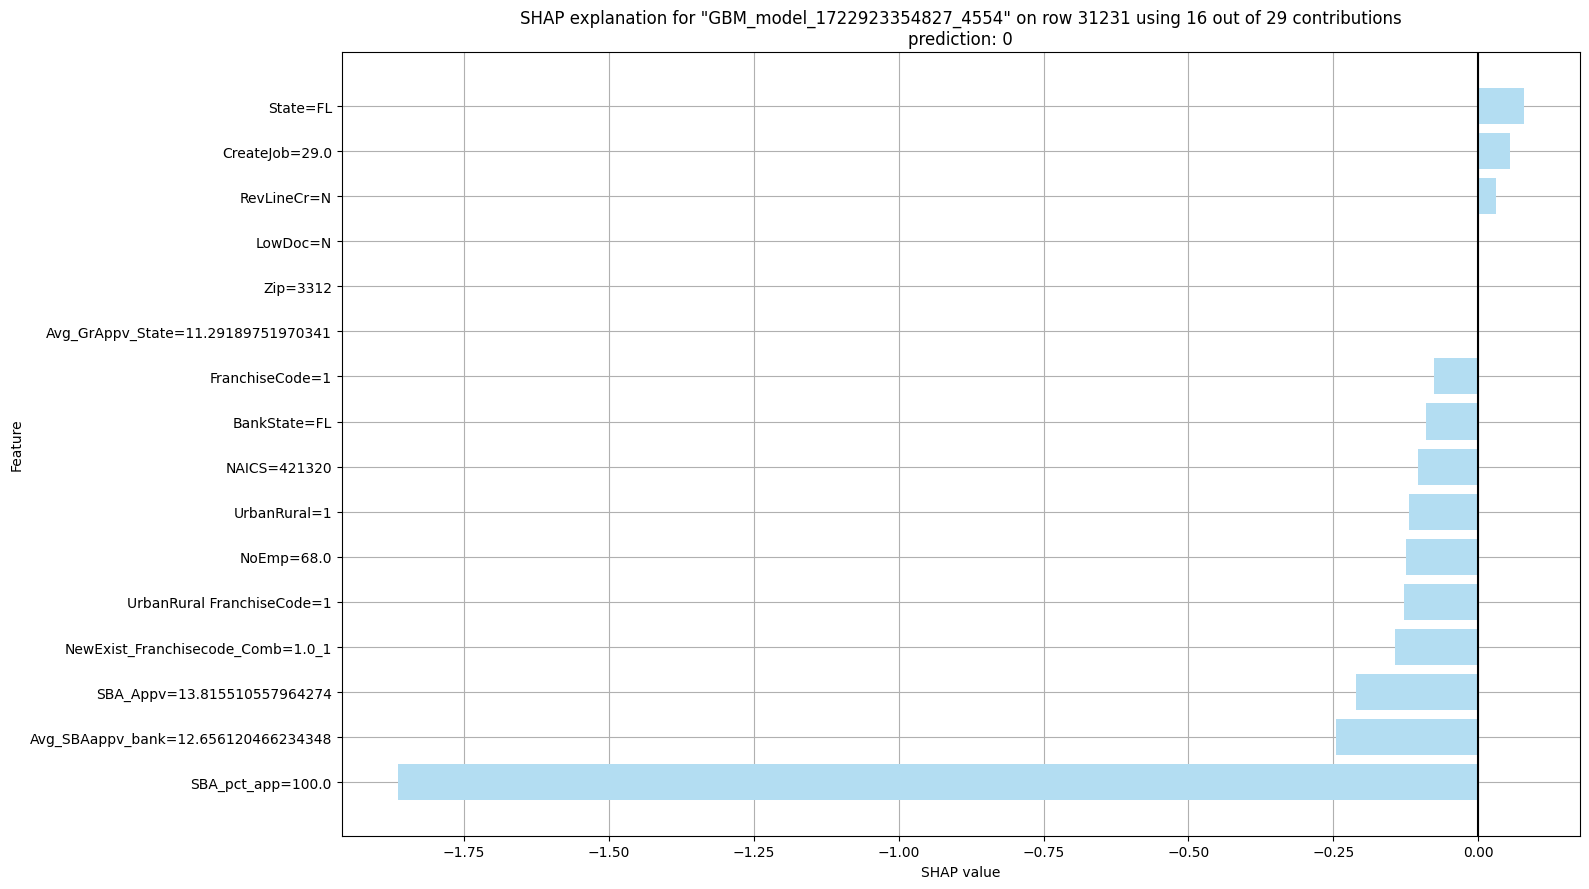

In [36]:
# 'MIS_Status' = 0, 'predict' = 0
best_model_h2o.shap_explain_row_plot(test_predict, row_index=31231)

'MIS_Status' = 0, 'predict' = 0

**Case 3:'MIS_Status' = 0, 'predict' = 0**
For this record of row_index = 31231, it is seen that the actual value 'MIS_Status' = 0 and the predicted 'MIS_Status' = 0. The 'p1' probability for this case = 0.00488814, which is quite less than the threshold value of  0.22954. This implies that this model predicts the target class **accurately with significant probabilty**. This means we can strongly say that the predicted class is **highly correct** as the predicted probability is much lower than the threshold value, implying that the residual value for this case is nearly 0.<br />
In this case, top most important feature is SBA_pct_aap with appx. -1.80 shap value followed by 'Avg_SBAappv_bank' with shap value appx. -0.25, 'SBA_Appv' (shap value appx. -0.2). We can see that, these features are contributing negatively especially the SBA_pct_app and hence decreasing the probability of p1, i.e. the chance of not getting defaulted. From, the Shap plot it is clear that most of the features are having negative shap values, thus contributing to a very low probability of p1. Only, 3 features are seen having a positive shap values and therefore their impact is negligible. Since, most of the features(10 in the plot) are having negative shap values compared to very less features of positive shap values(3 in the plot), with very less contribution, the additive of all these shap values to the 'biasterm' of -2.03 results in more negative value, which followed by the logit conversion is resulting in a very low 'p1' of 0.00488814 and thus prediction of 0.<br />
For this case the best_model_h2o has made significantly correct prediction.<br />

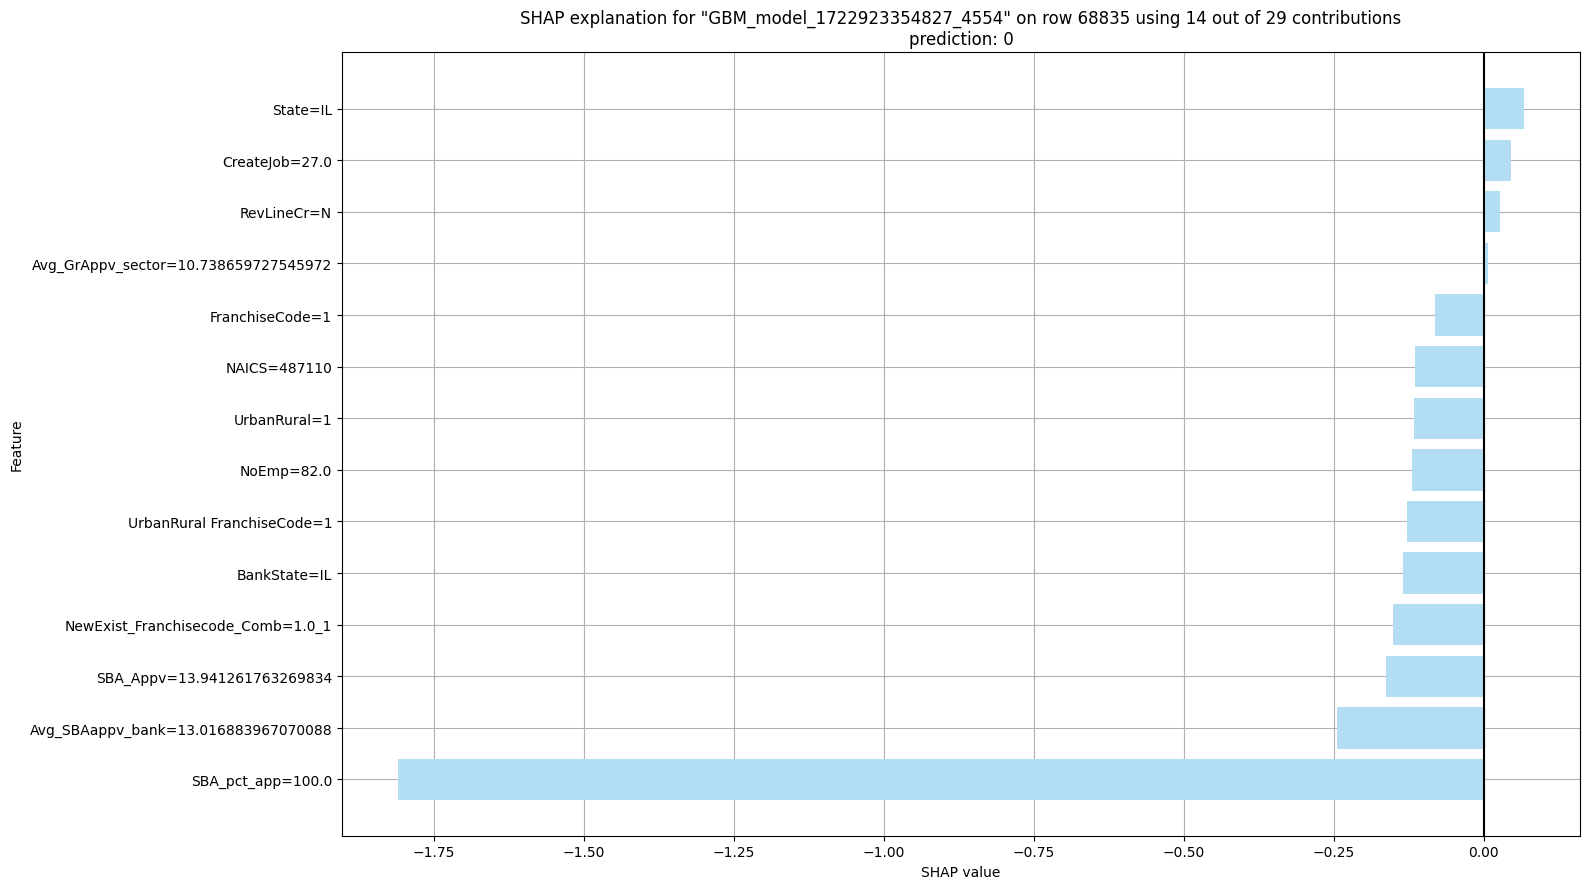

In [37]:
# 'MIS_Status' = 0, 'predict' = 0
best_model_h2o.shap_explain_row_plot(test_predict, row_index=68835)

**Case 3:'MIS_Status' = 0, 'predict' = 0**<br />
For this record of row_index = 68835, it is seen that the actual value 'MIS_Status' = 0 and the predicted 'MIS_Status' = 0. The 'p1' probability for this case = 0.00498501, which is quite less than the threshold value of  0.22954. This implies that this model predicts the target class **accurately with significant probabilty**. This means we can strongly say that the predicted class is **highly correct** as the predicted probability is much lower than the threshold value, implying that the residual value for this case is nearly 0.<br />
In this case, top most important feature is SBA_pct_aap with appx. -1.80 shap value followed by 'Avg_SBAappv_bank' with shap value appx. -0.25, 'SBA_Appv' (shap value appx. -0.2). We can see that, these features are contributing negatively especially the SBA_pct_app and hence decreasing the probability of p1, i.e. the chance of not getting defaulted. From, the Shap plot it is clear that most of the features are having negative shap values, thus contributing to a very low probability of p1. Only, 3 features are seen having a positive shap values and therefore their impact is negligible. Since, most of the features(10 in the plot) are having negative shap values compared to very less features of positive shap values(3 in the plot), with very less contribution, the additive of all these shap values to the 'biasterm' of -2.03 results in more negative value, which followed by the logit conversion is resulting in a very low 'p1' of 0.00498501 and thus prediction of 0.<br />
For this case the best_model_h2o has made significantly correct prediction.

In [38]:
condition4 = (test_predict_with_rows['MIS_Status'] == '0') & (test_predict_with_rows['predict'] == '1')
cols4 = test_predict_with_rows[condition4,:]
cols4.sort(by='p1', ascending=False)

predict,p0,p1,City,State,Zip,Bank,BankState,NAICS,NoEmp,NewExist,CreateJob,RetainedJob,RevLineCr,LowDoc,DisbursementGross,GrAppv,SBA_Appv,MIS_Status,sector,pct_job_retained,SBA_pct_app,NewExist_Franchisecode_Comb,Bank_BankState_Comb,Avg_SBAappv_bank,Avg_GrAppv_sector,Avg_GrAppv_State,Avg_Disb_Bank,UrbanRural,UrbanRural FranchiseCode,disb_greater_app,FranchiseCode,disb_greater_app FranchiseCode,row_index
1,0.0592856,0.940714,LOS ANGELES,CA,9003,BANK OF AMERICA NATL ASSOC,NC,711110,1,2,0,1,N,N,11.0509,10.4631,9.76996,0,"Arts, Entertainment, and Recreation",0,93.3753,2,BANK OF AMERICA NATL ASSOC_NC,9.88776,11.3782,11.6821,10.6855,1,0,1,0,0,73506
1,0.0613908,0.938609,JONESBORO,GA,3023,BANK OF AMERICA NATL ASSOC,NC,561720,11,1,2,11,Missing,N,12.0785,11.5129,10.8198,0,Administrative and Support and Waste Management and Remediation Services,550,93.9794,1,BANK OF AMERICA NATL ASSOC_NC,9.88776,10.7118,11.651,10.6855,1,0,1,0,0,20660
1,0.062153,0.937847,MARIETTA,GA,3006,BANK OF AMERICA NATL ASSOC,NC,524210,1,1,5,1,N,N,11.5074,11.2252,10.5321,0,Finance and Insurance,20,93.8251,1,BANK OF AMERICA NATL ASSOC_NC,9.88776,10.8983,11.651,10.6855,1,0,1,0,0,27514
1,0.0624666,0.937533,BROOKLYN,NY,1123,HSBC BK USA NATL ASSOC,VA,451130,2,1,0,2,Y,N,10.1266,10.1266,9.43348,0,Retail Trade,0,93.1552,1,HSBC BK USA NATL ASSOC_VA,10.5648,11.2011,11.0906,11.2474,1,0,0,0,0,101340
1,0.0656801,0.93432,NEW CITY,NY,1095,JPMORGAN CHASE BANK NATL ASSOC,OH,0,18,1,0,0,N,N,12.6115,12.6115,12.5062,0,Missing,0,99.1646,1,JPMORGAN CHASE BANK NATL ASSOC_OH,10.2897,11.8019,11.0906,11.21,0,0,0,0,0,90730
1,0.0660177,0.933982,CAPE CORAL,FL,3390,BANK OF AMERICA NATL ASSOC,NC,562910,6,1,1,6,Missing,N,11.2252,10.7144,10.0213,0,Administrative and Support and Waste Management and Remediation Services,600,93.5307,1,BANK OF AMERICA NATL ASSOC_NC,9.88776,10.7118,11.2919,10.6855,1,0,1,0,0,65358
1,0.0728739,0.927126,PEORIA,IL,6160,JPMORGAN CHASE BANK NATL ASSOC,IL,0,60,1,0,0,N,N,12.7657,12.7657,12.6603,0,Missing,0,99.1747,1,JPMORGAN CHASE BANK NATL ASSOC_IL,10.2897,11.8019,11.2737,11.21,0,0,0,0,0,118678
1,0.0736451,0.926355,MIAMI,FL,3318,BANK OF AMERICA NATL ASSOC,NC,561990,3,1,0,3,N,N,10.463,9.61581,8.92266,0,Administrative and Support and Waste Management and Remediation Services,0,92.7916,1,BANK OF AMERICA NATL ASSOC_NC,9.88776,10.7118,11.2919,10.6855,1,0,1,0,0,56633
1,0.0769193,0.923081,SAN FRANCISCO,CA,9412,BANK OF AMERICA NATL ASSOC,NC,541720,1,1,0,1,Missing,N,11.4636,10.8198,10.1266,0,"Professional, Scientific, and Technical Services",0,93.5937,1,BANK OF AMERICA NATL ASSOC_NC,9.88776,10.9699,11.6821,10.6855,1,0,1,0,0,21366
1,0.0785059,0.921494,FORT LAUDERDALE,FL,3332,BANK OF AMERICA NATL ASSOC,NC,423990,5,1,0,5,Missing,N,11.7269,11.5129,10.8198,0,Wholesale Trade,0,93.9794,1,BANK OF AMERICA NATL ASSOC_NC,9.88776,11.5624,11.2919,10.6855,1,0,1,0,0,16919


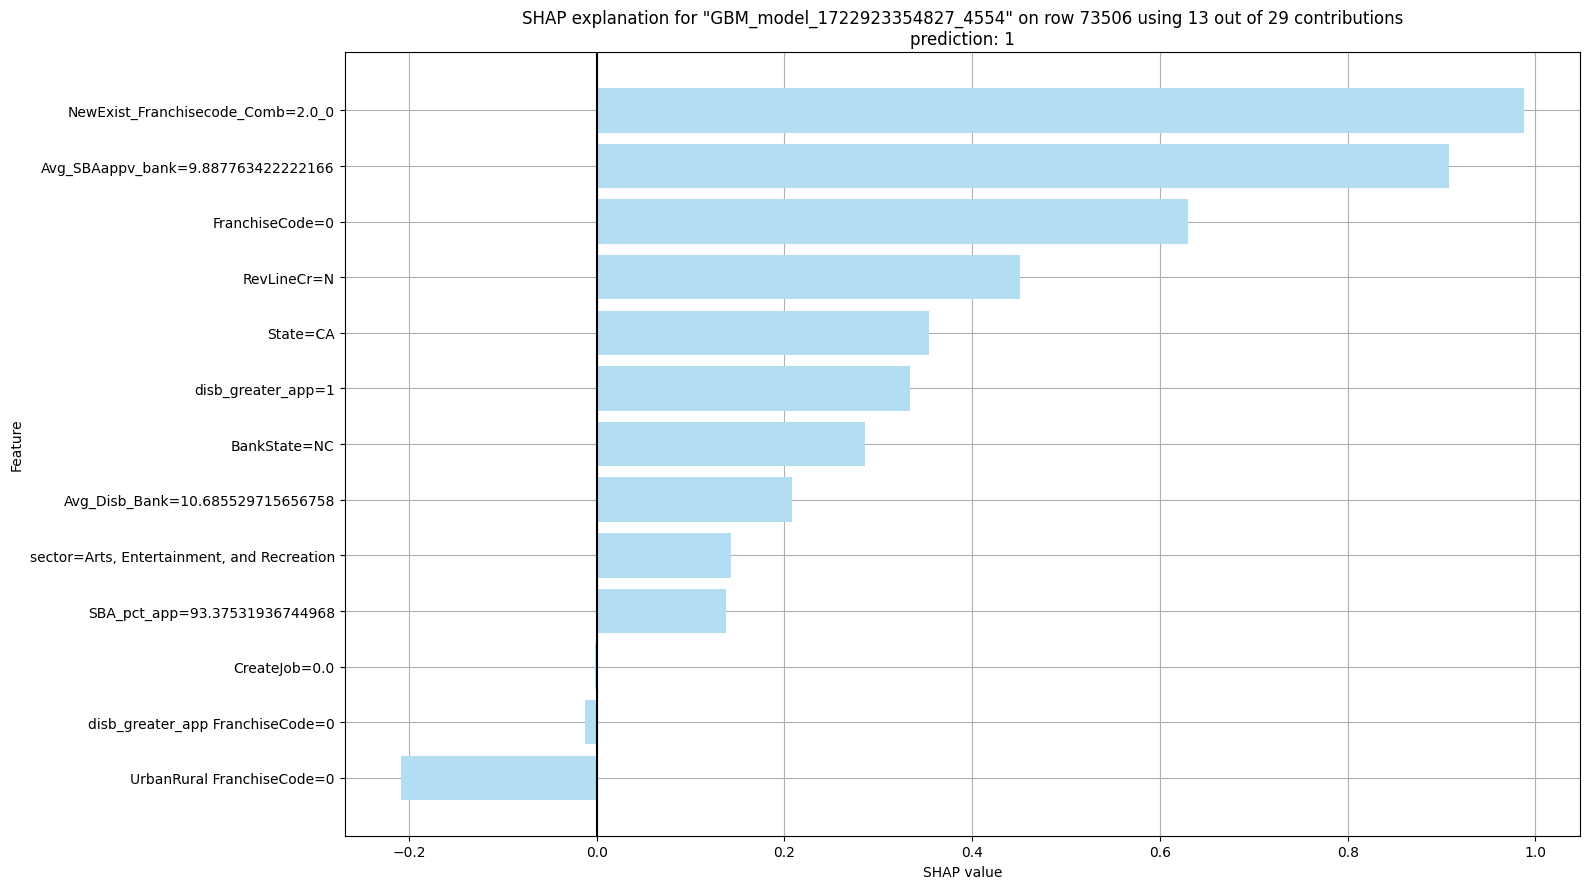

In [39]:
# 'MIS_Status' = 0, 'predict' = 1
best_model_h2o.shap_explain_row_plot(test_predict, row_index=73506)

**Case 4:'MIS_Status' = 0, 'predict' = 1**<br />
For this record of row_index = 73506, it is seen that the actual value 'MIS_Status' = 0 and the predicted 'MIS_Status' = 1. The 'p1' probability for this case = 0.940714, which is way more than the threshold value of 0.22954. This implies that this model predicts the target class **inaccurately with significant probabilty**. This means we can strongly say that the predicted class is **highly incorrect** as the predicted probability is much higher than the threshold value, implying that the residual value for this case is highly negative (-2.37714).<br />
In this case, top most important feature is NewExist_Franchisecode_Comb with appx. +1.0 shap value followed by 'Avg_SBAappv_bank' with appx. +0.9, 'FranchiseCode' (+0.6). We can see that, NewExist_Franchisecode_Comb (New Business and No Franchisecode), FranchiseCode = 0 (No franchise code)are contributing positively and hence increasing the probability of p1, i.e. the chance of getting defaulted. From, the Shap plot it is clear that most of the features are having positive shap values, thus contributing to higher probability of p1. Only, two features are seen having very less negative shap values and therefore their impact is negligible. Since, most of the features(10 in the plot) are having positive shap values compared to very less features of negative shap values (2 in the plot), with less contribution, the additive of all these shap values to the 'biasterm' of -2.03 results in positive value, which followed by the logit conversion is resulting in an high 'p1' of 0.940714 and thus prediction of 1.<br />
For this case the best_model_h2o has made significantly incorrect prediction.

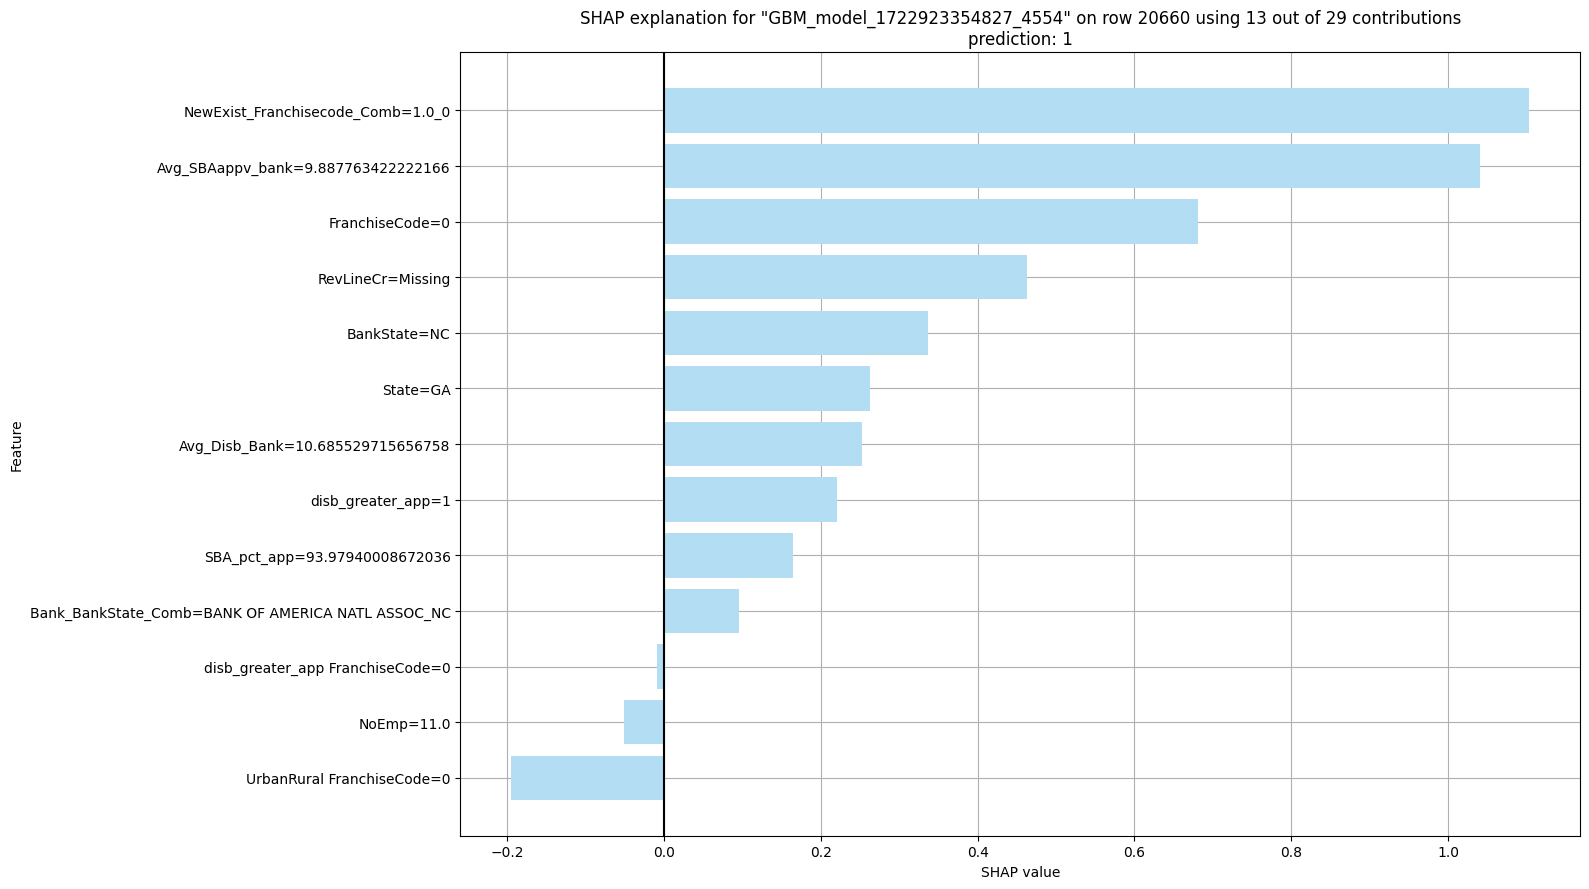

In [40]:
# 'MIS_Status' = 0, 'predict' = 1
best_model_h2o.shap_explain_row_plot(test_predict, row_index=20660)

**Case 4:'MIS_Status' = 0, 'predict' = 1**<br />
For this record of row_index = 73506, it is seen that the actual value 'MIS_Status' = 0 and the predicted 'MIS_Status' = 1. The 'p1' probability for this case = 0.938609, which is way more than the threshold value of 0.22954. This implies that this model predicts the target class **inaccurately with significant probabilty**. This means we can strongly say that the predicted class is **highly incorrect** as the predicted probability is much higher than the threshold value, implying that the residual value for this case is highly negative (-2.36241).<br />
In this case, top most important feature is NewExist_Franchisecode_Comb with appx. +1.5 shap value followed by 'Avg_SBAappv_bank' with appx. +1.0, 'FranchiseCode' (+0.7). We can see that, NewExist_Franchisecode_Comb (Existing Business and No Franchisecode), FranchiseCode = 0 (No franchise code)are contributing positively and hence increasing the probability of p1, i.e. the chance of getting defaulted. From, the Shap plot it is clear that most of the features are having positive shap values, thus contributing to higher probability of p1. Only, three features are seen having very less negative shap values and therefore their impact is negligible. Since, most of the features(10 in the plot) are having positive shap values compared to very less features of negative shap values (3 in the plot), with less contribution, the additive of all these shap values to the 'biasterm' of -2.03 results in positive value, which followed by the logit conversion is resulting in an high 'p1' of 0.938609 and thus prediction of 1.<br />
For this case the best_model_h2o has made significantly incorrect prediction.

In [41]:
test_predict

predict,p0,p1,City,State,Zip,Bank,BankState,NAICS,NoEmp,NewExist,CreateJob,RetainedJob,RevLineCr,LowDoc,DisbursementGross,GrAppv,SBA_Appv,MIS_Status,sector,pct_job_retained,SBA_pct_app,NewExist_Franchisecode_Comb,Bank_BankState_Comb,Avg_SBAappv_bank,Avg_GrAppv_sector,Avg_GrAppv_State,Avg_Disb_Bank,UrbanRural,UrbanRural FranchiseCode,disb_greater_app,FranchiseCode,disb_greater_app FranchiseCode
0,0.955035,0.0449654,East Wilton,ME,4234,"TD BANK, NATIONAL ASSOCIATION",DE,621210,7,1,0,7,N,N,11.9184,11.9197,11.632,0,Health Care and Social Assistance,0,97.5865,1,"TD BANK, NATIONAL ASSOCIATION_DE",11.1103,11.5122,11.1633,11.5413,2,0,0,0,0
0,0.967474,0.0325264,REDWAY,CA,9566,NORTH VALLEY BANK,CA,454110,18,1,0,0,N,N,12.9239,12.9239,12.6362,0,Retail Trade,0,97.774,1.01,NORTH VALLEY BANK_CA,11.4636,11.2011,11.6821,11.6588,0,0,0,1,0
0,0.92257,0.0774301,CORTLAND,NY,1304,MANUFACTURERS & TRADERS TR CO,NY,0,150,2,0,0,N,N,12.5062,12.5062,12.1351,0,Missing,0,97.033,2.01,MANUFACTURERS & TRADERS TR CO_NY,10.8665,11.8019,11.0906,11.4529,0,0,0,1,0
0,0.799739,0.200261,YONKERS,NY,1070,CAPITAL ONE NATL ASSOC,VA,238190,7,1,0,7,N,N,10.4631,10.4631,9.76996,1,Construction,0,93.3753,1.01,CAPITAL ONE NATL ASSOC_VA,9.98822,11.0177,11.0906,10.7267,1,1,0,1,0
0,0.947075,0.0529253,LEAGUE CITY,TX,7757,PEARLAND STATE BANK,TX,0,8,1,0,0,N,Y,11.0821,11.0821,10.8958,0,Missing,0,98.3187,1.01,PEARLAND STATE BANK_TX,10.9408,11.8019,11.499,11.0567,0,0,0,1,0
0,0.901516,0.0984835,PEMBERTON,NJ,8068,HOPEWELL VALLEY COMMUNITY BANK,NJ,238320,7,1,0,0,N,Y,11.2252,11.2252,11.0627,0,Construction,0,98.5522,1.01,HOPEWELL VALLEY COMMUNITY BANK_NJ,11.226,11.0177,11.378,11.6459,1,1,0,1,0
0,0.926277,0.073723,TIJERAS,NM,8705,WELLS FARGO BANK NATL ASSOC,SD,624410,11,1,0,0,N,N,11.6742,11.6742,11.3865,1,Health Care and Social Assistance,0,97.5357,1.01,WELLS FARGO BANK NATL ASSOC_SD,11.2498,11.5122,11.479,11.7281,0,0,0,1,0
1,0.691868,0.308132,CAPE CORAL,FL,3399,CAPITAL ONE NATL ASSOC,VA,424210,3,1,0,3,N,N,10.1266,10.1266,9.43348,0,Wholesale Trade,0,93.1552,1.01,CAPITAL ONE NATL ASSOC_VA,9.98822,11.5624,11.2919,10.7267,1,1,0,1,0
0,0.945981,0.0540195,FRESNO,CA,9370,FIRST-CITIZENS BK & TR CO,NC,621111,3,1,0,0,N,N,12.8069,13.0677,12.78,0,Health Care and Social Assistance,0,97.7985,1.01,FIRST-CITIZENS BK & TR CO_NC,12.2618,11.5122,11.6821,12.5255,1,1,0,1,0
0,0.830163,0.169837,MAYWOOD,IL,6015,INLAND BANK & TRUST,IL,484121,45,1,0,0,N,N,14.4143,14.4143,13.7982,0,Transportation and Warehousing,0,95.7252,1.01,INLAND BANK & TRUST_IL,11.7922,10.7387,11.2737,12.102,1,1,0,1,0


In [42]:
yhat = 'p_Default'
resid = 'r_DEFAULT' #Residuals
preds1 = best_model_h2o.predict(test).drop(['predict', 'p0'])
preds1.columns = [yhat] #'p1'
test_yhat = test.cbind(preds1[yhat])

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [43]:
test_yhat = test_yhat.as_data_frame()
test_yhat['s'] = 1
test_yhat.loc[test_yhat['MIS_Status'] == 0, 's'] = -1

#Residual Calculation
test_yhat['r_DEFAULT'] = test_yhat['s'] * np.sqrt(-2*(test_yhat['MIS_Status']*np.log(test_yhat[yhat]) +
                                                                 ((1 - test_yhat['MIS_Status'])*np.log(1 - test_yhat[yhat]))))
test_yhat = test_yhat.drop('s', axis=1)

Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


In [44]:
test_yhat   # with Residual values for each record

,City,State,Zip,Bank,BankState,NAICS,NoEmp,NewExist,CreateJob,RetainedJob,RevLineCr,LowDoc,DisbursementGross,GrAppv,SBA_Appv,MIS_Status,sector,pct_job_retained,SBA_pct_app,NewExist_Franchisecode_Comb,Bank_BankState_Comb,Avg_SBAappv_bank,Avg_GrAppv_sector,Avg_GrAppv_State,Avg_Disb_Bank,UrbanRural,UrbanRural FranchiseCode,disb_greater_app,FranchiseCode,disb_greater_app FranchiseCode,p_Default,r_DEFAULT
0,East Wilton,ME,4234,"TD BANK, NATIONAL ASSOCIATION",DE,621210,7,1,0,7,N,N,11.918391,11.919723,11.632041,0,Health Care and Social Assistance,0.0,97.586504,1.0_0,"TD BANK, NATIONAL ASSOCIATION_DE",11.110311,11.512156,11.163279,11.541285,2,0,0,0,0,0.044965,-0.303340
1,REDWAY,CA,9566,NORTH VALLEY BANK,CA,454110,18,1,0,0,N,N,12.923912,12.923912,12.636230,0,Retail Trade,0.0,97.774033,1.0_1,NORTH VALLEY BANK_CA,11.463612,11.201094,11.682131,11.658782,0,0,0,1,0,0.032526,-0.257166
2,CORTLAND,NY,1304,MANUFACTURERS & TRADERS TR CO,NY,0,150,2,0,0,N,N,12.506177,12.506177,12.135114,0,Missing,0.0,97.032957,2.0_1,MANUFACTURERS & TRADERS TR CO_NY,10.866459,11.801862,11.090644,11.452927,0,0,0,1,0,0.077430,-0.401478
3,YONKERS,NY,1070,CAPITAL ONE NATL ASSOC,VA,238190,7,1,0,7,N,N,10.463103,10.463103,9.769956,1,Construction,0.0,93.375319,1.0_1,CAPITAL ONE NATL ASSOC_VA,9.988223,11.017687,11.090644,10.726746,1,1,0,1,0,0.200261,1.793396
4,LEAGUE CITY,TX,7757,PEARLAND STATE BANK,TX,0,8,1,0,0,N,Y,11.082143,11.082143,10.895813,0,Missing,0.0,98.318650,1.0_1,PEARLAND STATE BANK_TX,10.940788,11.801862,11.499032,11.056653,0,0,0,1,0,0.052925,-0.329780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159867,AUGUSTA,ME,4330,BANK OF AMERICA NATL ASSOC,RI,445110,3,1,1,4,N,N,8.517193,8.517193,7.824046,0,Retail Trade,400.0,91.861789,1.0_1,BANK OF AMERICA NATL ASSOC_RI,9.887763,11.201094,11.163279,10.685530,1,1,0,1,0,0.074089,-0.392369
159868,STERLING HEIGHTS,MI,4831,FIFTH THIRD BANK,OH,339999,5,1,2,5,Y,N,13.068239,11.512925,10.819778,0,Manufacturing,250.0,93.979400,1.0_1,FIFTH THIRD BANK_OH,11.352635,11.691626,11.381327,11.701119,1,1,1,1,1,0.070804,-0.383238
159869,RUTHERFORD,NJ,7070,"PNC BANK, NATIONAL ASSOCIATION",DE,448310,4,1,1,4,Y,N,10.714418,10.714418,10.021271,1,Retail Trade,400.0,93.530706,1.0_1,"PNC BANK, NATIONAL ASSOCIATION_DE",10.596429,11.201094,11.378002,11.231754,1,1,0,1,0,0.208884,1.769732
159870,HOLTSVILLE,NY,1174,"CITIBANK, N.A.",NY,443120,1,1,2,2,Y,N,10.596635,10.596635,9.903488,0,Retail Trade,100.0,93.458799,1.0_1,"CITIBANK, N.A._NY",10.395882,11.201094,11.090644,11.119809,1,1,0,1,0,0.112411,-0.488357


In [45]:
test_yhat = h2o.H2OFrame(test_yhat)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [46]:
# Sort the data frame in descending order by residual values.
sorted_test_yhat = test_yhat.sort('r_DEFAULT', ascending=False)
sorted_test_yhat #With highly positive residuals on top

City,State,Zip,Bank,BankState,NAICS,NoEmp,NewExist,CreateJob,RetainedJob,RevLineCr,LowDoc,DisbursementGross,GrAppv,SBA_Appv,MIS_Status,sector,pct_job_retained,SBA_pct_app,NewExist_Franchisecode_Comb,Bank_BankState_Comb,Avg_SBAappv_bank,Avg_GrAppv_sector,Avg_GrAppv_State,Avg_Disb_Bank,UrbanRural,UrbanRural FranchiseCode,disb_greater_app,FranchiseCode,disb_greater_app FranchiseCode,p_Default,r_DEFAULT
OKLAHOMA CITY,OK,7311,NBANC,OK,924110,1,1,0,0,N,Y,10.7608,11.1377,11.0324,1,Public Administration,0,99.0541,1.01,NBANC_OK,10.965,10.8788,11.4422,11.1775,0,0,0,1,0,0.0112786,2.99494
OAK PARK HEIGHTS,MN,5508,LAKE ELMO BANK,MN,336992,500,1,0,0,Y,N,14.221,14.221,14.1156,1,Manufacturing,0,99.2591,1.01,LAKE ELMO BANK_MN,11.3235,11.6916,11.545,11.7352,1,1,0,1,0,0.0120112,2.97386
Montclair (township of),NJ,7043,THE PROVIDENT BANK,NJ,445299,20,2,0,20,N,N,13.6762,13.7851,13.6797,1,Retail Trade,0,99.2357,2.01,THE PROVIDENT BANK_NJ,11.6706,11.2011,11.378,12.0828,1,1,0,1,0,0.0122309,2.96776
MONTICELLO,KY,4263,GERMAN AMER BANCORP D/B/A GERM,IN,112320,2,2,0,0,N,N,12.7441,12.7455,12.583,1,"Agriculture, Forestry, Fishing and Hunting",0,98.7249,2.01,GERMAN AMER BANCORP D/B/A GERM_IN,11.9352,11.8042,11.2793,12.1267,0,0,0,1,0,0.012999,2.94716
SEATTLE,WA,9810,WELLS FARGO BANK NATL ASSOC,SD,339911,7,1,0,0,N,N,11.5129,11.5129,11.4076,1,Manufacturing,0,99.0849,1.01,WELLS FARGO BANK NATL ASSOC_SD,11.2498,11.6916,11.4177,11.7281,0,0,0,1,0,0.0137698,2.92755
ANNANDALE,VA,2200,UNITED BANK,VA,541921,1,1,0,0,N,Y,10.2805,10.9569,10.8516,1,"Professional, Scientific, and Technical Services",0,99.0384,1.01,UNITED BANK_VA,11.1639,10.9699,11.3212,11.4434,0,0,0,1,0,0.0141414,2.91844
WHITE PIGEON,MI,4909,MUTUALBANK,IN,336214,68,1,0,0,Y,N,13.7902,13.7902,13.6848,1,Manufacturing,0,99.236,1.01,MUTUALBANK_IN,11.9898,11.6916,11.3813,12.227,2,2,0,1,0,0.0151312,2.89517
HARAHAN,LA,7012,WHITNEY BANK,MS,0,3,1,0,0,N,Y,11.2645,11.2645,11.1366,1,Missing,0,98.8652,1.01,WHITNEY BANK_MS,11.2631,11.8019,11.2267,11.5034,0,0,0,1,0,0.0153404,2.89042
KEENE,NH,3431,"TD BANK, NATIONAL ASSOCIATION",NH,541110,1,2,0,0,N,Y,10.4631,10.4631,10.3577,1,"Professional, Scientific, and Technical Services",0,98.993,2.01,"TD BANK, NATIONAL ASSOCIATION_NH",11.1103,10.9699,11.0071,11.5413,0,0,0,1,0,0.0155446,2.88584
RENTON,WA,9805,BANK OF AMERICA NATL ASSOC,NC,453210,20,1,0,0,N,N,13.5924,13.5924,13.4298,1,Retail Trade,0,98.8043,1.01,BANK OF AMERICA NATL ASSOC_NC,9.88776,11.2011,11.4177,10.6855,0,0,0,1,0,0.0161311,2.87298


In [47]:
sorted_test_yhat.tail() #Gives records with highly negative resdual values

City,State,Zip,Bank,BankState,NAICS,NoEmp,NewExist,CreateJob,RetainedJob,RevLineCr,LowDoc,DisbursementGross,GrAppv,SBA_Appv,MIS_Status,sector,pct_job_retained,SBA_pct_app,NewExist_Franchisecode_Comb,Bank_BankState_Comb,Avg_SBAappv_bank,Avg_GrAppv_sector,Avg_GrAppv_State,Avg_Disb_Bank,UrbanRural,UrbanRural FranchiseCode,disb_greater_app,FranchiseCode,disb_greater_app FranchiseCode,p_Default,r_DEFAULT
FORT LAUDERDALE,FL,3332,BANK OF AMERICA NATL ASSOC,NC,423990,5,1,0,5,Missing,N,11.7269,11.5129,10.8198,0,Wholesale Trade,0,93.9794,1,BANK OF AMERICA NATL ASSOC_NC,9.88776,11.5624,11.2919,10.6855,1,0,1,0,0,0.921494,-2.25592
SAN FRANCISCO,CA,9412,BANK OF AMERICA NATL ASSOC,NC,541720,1,1,0,1,Missing,N,11.4636,10.8198,10.1266,0,"Professional, Scientific, and Technical Services",0,93.5937,1,BANK OF AMERICA NATL ASSOC_NC,9.88776,10.9699,11.6821,10.6855,1,0,1,0,0,0.923081,-2.26495
MIAMI,FL,3318,BANK OF AMERICA NATL ASSOC,NC,561990,3,1,0,3,N,N,10.463,9.61581,8.92266,0,Administrative and Support and Waste Management and Remediation Services,0,92.7916,1,BANK OF AMERICA NATL ASSOC_NC,9.88776,10.7118,11.2919,10.6855,1,0,1,0,0,0.926355,-2.28407
PEORIA,IL,6160,JPMORGAN CHASE BANK NATL ASSOC,IL,0,60,1,0,0,N,N,12.7657,12.7657,12.6603,0,Missing,0,99.1747,1,JPMORGAN CHASE BANK NATL ASSOC_IL,10.2897,11.8019,11.2737,11.21,0,0,0,0,0,0.927126,-2.28868
CAPE CORAL,FL,3390,BANK OF AMERICA NATL ASSOC,NC,562910,6,1,1,6,Missing,N,11.2252,10.7144,10.0213,0,Administrative and Support and Waste Management and Remediation Services,600,93.5307,1,BANK OF AMERICA NATL ASSOC_NC,9.88776,10.7118,11.2919,10.6855,1,0,1,0,0,0.933982,-2.33145
NEW CITY,NY,1095,JPMORGAN CHASE BANK NATL ASSOC,OH,0,18,1,0,0,N,N,12.6115,12.6115,12.5062,0,Missing,0,99.1646,1,JPMORGAN CHASE BANK NATL ASSOC_OH,10.2897,11.8019,11.0906,11.21,0,0,0,0,0,0.93432,-2.33365
BROOKLYN,NY,1123,HSBC BK USA NATL ASSOC,VA,451130,2,1,0,2,Y,N,10.1266,10.1266,9.43348,0,Retail Trade,0,93.1552,1,HSBC BK USA NATL ASSOC_VA,10.5648,11.2011,11.0906,11.2474,1,0,0,0,0,0.937533,-2.35505
MARIETTA,GA,3006,BANK OF AMERICA NATL ASSOC,NC,524210,1,1,5,1,N,N,11.5074,11.2252,10.5321,0,Finance and Insurance,20,93.8251,1,BANK OF AMERICA NATL ASSOC_NC,9.88776,10.8983,11.651,10.6855,1,0,1,0,0,0.937847,-2.35718
JONESBORO,GA,3023,BANK OF AMERICA NATL ASSOC,NC,561720,11,1,2,11,Missing,N,12.0785,11.5129,10.8198,0,Administrative and Support and Waste Management and Remediation Services,550,93.9794,1,BANK OF AMERICA NATL ASSOC_NC,9.88776,10.7118,11.651,10.6855,1,0,1,0,0,0.938609,-2.36241
LOS ANGELES,CA,9003,BANK OF AMERICA NATL ASSOC,NC,711110,1,2,0,1,N,N,11.0509,10.4631,9.76996,0,"Arts, Entertainment, and Recreation",0,93.3753,2,BANK OF AMERICA NATL ASSOC_NC,9.88776,11.3782,11.6821,10.6855,1,0,1,0,0,0.940714,-2.37714


# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

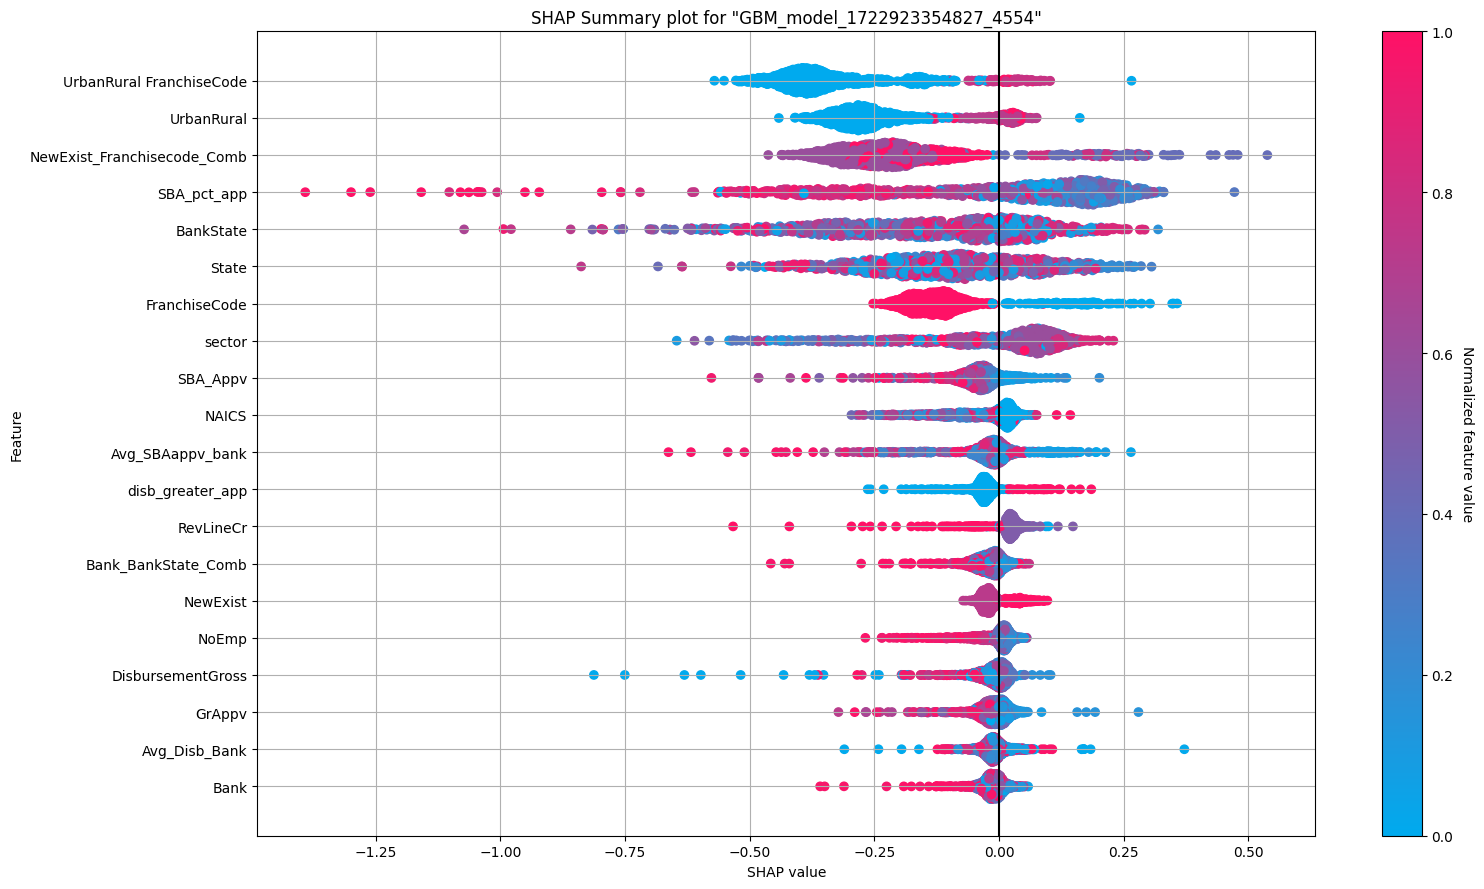

In [48]:
best_model_h2o.explain(frame=sorted_test_yhat[0:1000,: ],include_explanations =['shap_summary']);

**Residual analysis**<br />
The above Plot is a Shap summary plot on the records where the residuals are highly positive. We have plotted top 1000 records to know which features are contributing the most in residuals. Highly positive residuals imply that these in these cases the observations whose actual 'MIS_Status' = 1(Default), is being predicted as 0 (not default). The top contributing features in highly positive residuals are 'UrbanRural FranchiseCode', 'UrbanRural', 'NewExist_Franchisecode_Comb', 'SBA_pct_app', 'BankState'. The feature UrbanRural FranchiseCode, has most of the shap values as negative. Same is the the case with UrbanRural and NewExist_Franchisecode_Comb as well. It is evident that the positive shap values range from 0 to 0.5, but the the negative shap values range upto -1.3. These highly negative shap values are contributing in the lower probability and thus high positive residuals.

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

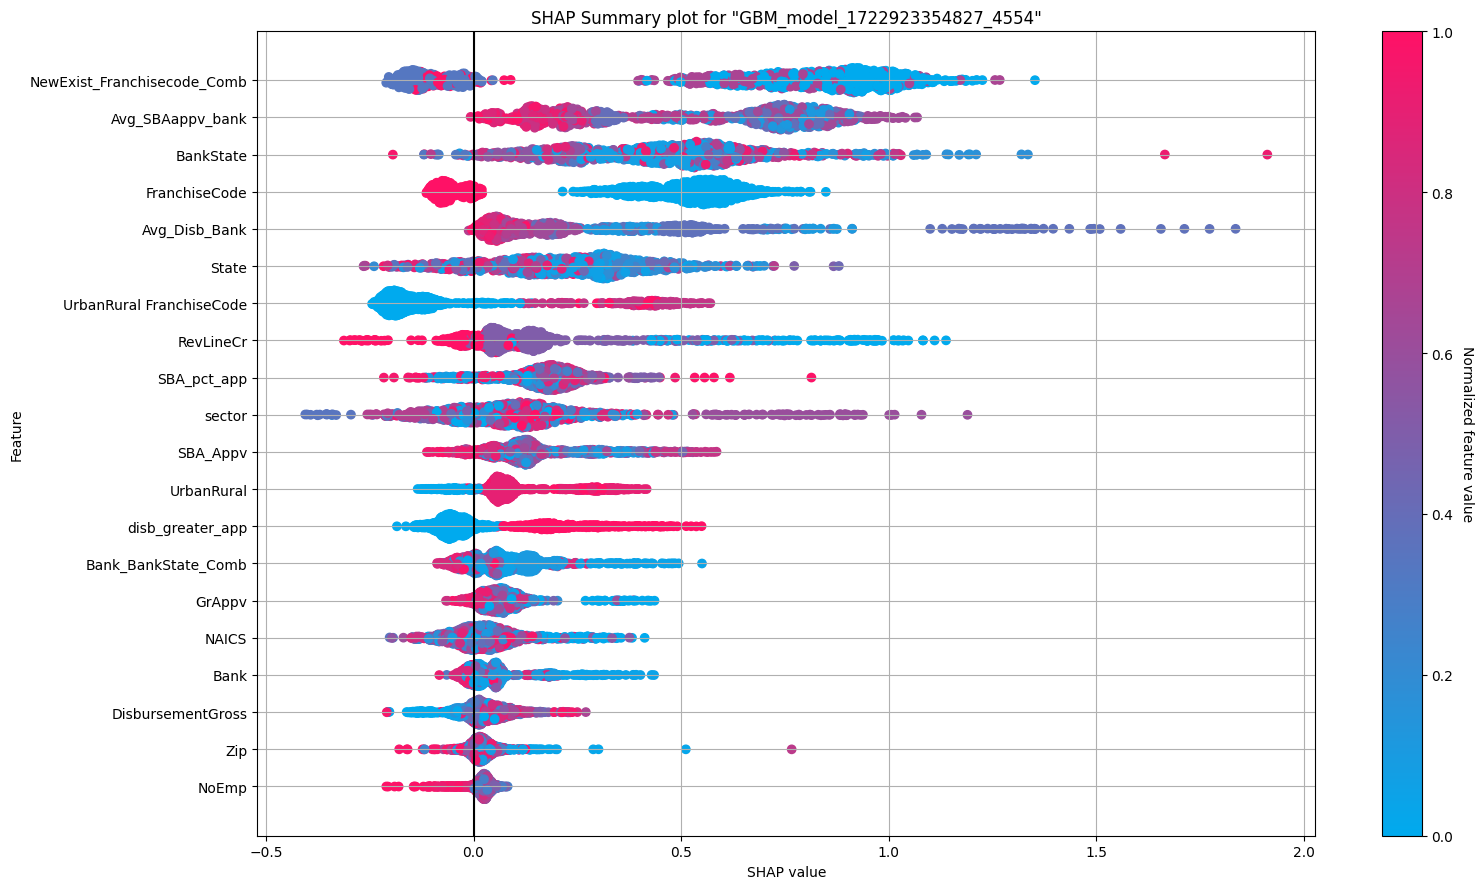

In [49]:
best_model_h2o.explain(frame=sorted_test_yhat[-1000:,: ],include_explanations =['shap_summary']);

**Residual analysis**<br />
The above Plot is a Shap summary plot on the records where the residuals are highly negative. We have plotted top 1000 records with negative residuals to know which features are contributing the most in residuals. Highly negative residuals imply that these in these cases the observations whose actual 'MIS_Status' = 0(Not Default), is being predicted as 1 (Default). The top contributing features in highly negative residuals are 'NewExist_Franchisecode_Comb', 'Avg_SBAappv_Bank','BankState', 'FranchiseCode', 'Avg_Disb_Bank'. The features NewExist_Franchisecode_Comb have most of the shap values as positive. Same is the the case with other features in the plot. It is evident that the positive shap values range from 0 to 2.0, but the the negative shap values range upto -0.5. These highly positive shap values are contributing in the higher probability and thus high negative residuals.

In [50]:
# Create artifacts folder and dump the functions created earlier into it. Create a model path of the best_model_h2o in H2o dataframe and dump it
# into the artifacts folder.

import pickle
import os
import inspect

artifacts_dir = "./artifacts"
os.makedirs(artifacts_dir, exist_ok=True)

# Save the H2O model
model_path = h2o.save_model(model=best_model_h2o, path=artifacts_dir, force=True)

# Create the artifacts_dict
artifacts_dict = {
    "model_path": model_path,
}

with open(os.path.join(artifacts_dir, "artifacts_model_path.pkl"), "wb") as artifacts_model_path_file:
    pickle.dump(artifacts_dict, artifacts_model_path_file)

# List of functions to save
function_names = [
    "data_cleaning",
    "new_features_1",
    "Bank_SBAappv_mapping",
    "sector_GrAppv_mapping",
    "State_GrAppv_mapping",
    "Disb_Bank_mapping",
    "add_interaction_terms",
    "changing_datatype"
]

# Create a dictionary with function names as keys and source code as values
functions_dict = {}
for name in function_names:
    obj = globals().get(name)
    if obj:
        if inspect.isfunction(obj) or inspect.ismethod(obj):
            functions_dict[name] = inspect.getsource(obj)
        elif isinstance(obj, dict):
            functions_dict[name] = obj
        else:
            print(f"Warning: {name} is not a function, method, or dictionary.")

# Save the functions as strings
with open(os.path.join(artifacts_dir, "artifacts_functions.pkl"), "wb") as artifacts_functions_file:
    pickle.dump(functions_dict, artifacts_functions_file)

**SUMMARY OF WORK**<br />
The above project is a Classifier problem where we have to predict whether the loan will be defaulted or not defaulted. We are given a data set of 799356 records and 18 columns (excluding the 'index' and 'MIS_Status'). MIS_Status is the target column. We have 18 predictor columns -'City', 'State', 'Zip', 'Bank', 'BankState', 'NAICS', 'NoEmp', 'NewExist', 'CreateJob', 'RetainedJob', 'RevLineCr', 'LowDoc', 'DisbursementGross', 'BalanceGross', 'GrAppv', 'SBA_Appv',' 'UrbanRural','FranchiseCode'. We check for the missing values in the columns where it is found that 'City' has 25 missing values, 'State' has 12 missing values, 'Bank' has 1402 missing values, 'BankState' has 1408 missing values, NewExist has 114 missing values, RevLineCr has 4025 missing values and LowDoc has 2300 missing values.<br />

**Splitting the data**<br />
We split the data into X_train, X_valid, X_test in the ratio of 60:20:20. We use the training dataset to training the model and evaluate the model using the validation dataset. We use test dataset (unseen data) to display the performance metrics of the best model.

**Data Cleaning**<br />
In data cleaning we have initially, created a function to clean the data and use it further during scoring of new data. We have replaced missing values in columns with 0 and 'Missing' if the column data type is numeric or object respectively. Further, in RevLineCr - Revolving line of credit(either Yes or No) is a categorical column. We have replaced values of 0 or N with N and 1 or Y with Y and any value other than this with 'Missing'.Similarly, We replace values of 0 or N with N and 1 or Y with Y and any value other than this with 'Missing'in the column of LowDoc.In the column FranchiseCode, we replace the values other than 0 or 1 with 1.<br />
We create new column, sector by extracting the first two digits from the NAICS. We create a dictionary of the digits and corresponding sector and map them accordingly to create the column sector.<br /> 
We then extract the first 4 digits from the Zip column as this captures a lot more information by reducing the Noise and allowing to focus on the underlying pattern.<br />
We then drop the column 'BalanceGross'. We can see that the values of BalanceGross other than 0 are very less (75th percentile of 'BalanceGross' is also 0), and hence is not contributing in model prediction. We can also see that the number of records of 'BalanceGross' > 0 in 799356 records is only 13, which is highly negligible which may result in the Noise in data. Hence, this fails to capture any important information and removing this column can increase the model performance.<br /> 
We perform log transformations on the amount columns - 'DisbursementGross', 'SBA_Appv', 'GrAppv', to remove the skewness if there is any.
We the call the function data_cleaning on X_train, X_valid, X_test to perform data cleaning on the three data sets separately.<br />

**Model performance before feature Engineering and hyper tuning using default parameters**<br />
We have created a gbm model after performing data cleaning and calculated it's AUC which is 0.805225. Our target is to introduce new features (atleast 10) to improve the model performance. 

**New feature Addition**<br />
We create a function 'new_features_1' to add engineering features. In function 'new_features_1' we added 5 new features.<br /> 
'pct_job_retained' - percentage of job retained which is calculated by taking the percentage of 'RetainedJob' with respect to 'CreatedJob'.<br />
'SBA_pct_app' - percentage of SBA_loan_approved which is calculated by taking the percentage of 'SBA_Appv' as a percentage of 'GrAppv'.<br />
'disb_greater_app' - gives a value 1 if the DisbursementGross is greater than GrAppv and 0 otherwise.<br />
'NewExist_Franchisecode_Comb'- It is a combination column of 'NewExist' and 'FranchiseCode'.<br />
'Bank_BankState_Comb'- It is a combination column of 'Bank' and 'BankState'.<br />
We call this function new_features_1 on the datasets X_train, X_valid, X_test, to add the new features.<br />
We create another function 'new_features_2' to add 4 new engineering features.<br />
'Avg_SBAappv_bank'- We create this column by calculating grouped mean of the SBA_Appv on the Bank.<br />
'Avg_GrAppv_sector' - We create this column by calculating grouped mean of the GrAppv on sectors.<br />
'Avg_GrAppv_State' - We create this column by calculating grouped mean of the GrAppv on State.<br />
'Avg_Disb_Bank'- We create this column by calculating grouped mean of DisburseGross on Bank.<br />
We use this function add this new features in X_train.<br />
We then create dictionaries 'Bank_SBAappv_mapping','sector_GrAppv_mapping','State_GrAppv_mapping','Disb_Bank_mapping' to store the values created during the new feature addition in the X_train. We map these stored values in the X_valid and X_test separately, by mapping them based on Bank, sector, State accordingly.<br />
We create another function add_interaction_terms where we create interaction terms of - ('UrbanRural' and 'FranchiseCode') and  ('disb_greater_app' and 'FranchiseCode'). We add these interaction terms in  X_train, X_valid, X_test by calling the function 'add_interaction_terms'.<br />
By this we completed our features addion. In total we have added 11 engineering features into the data sets.<br />

**Changing the dataframe**<br />
We now change the datasets to H2O dataframe and save them as X_train_h2o, X_valid_h2o, X_test_h2o.

**Changing the datatype**<br />
We then change the datatype of the columns as per the requirement. We  create a function 'changing_datatype'.<br />
'City', 'State', 'Zip', 'Bank', 'BankState', 'NAICS', 'NewExist', 'sector', 'NewExist_Franchisecode_Comb', 'Bank_BankState_Comb','UrbanRural', 'UrbanRural FranchiseCode', 'disb_greater_app', 'FranchiseCode', 'disb_greater_app FranchiseCode' - We convert the dataype of these columns to categorical type using asfactor(). We change the rest of the columns dataype to asnumeric().
We call this function X_train_h2o, X_valid_h2o, X_test_h2o.<br />
We then change the datatype of 'MIS_Status' to categorical and drop the 'index' column as it will not be used in the model training.<br />

**Model performance after feature Engineering and hyper tuning using default parameters**<br />
We can see than on addition of new features:'pct_job_retained', 'SBA_pct_app', 'NewExist_Franchisecode_Comb', 'Bank_BankState_Comb', 'Avg_SBAappv_bank', 'Avg_GrAppv_sector', 'Avg_GrAppv_State', 'Avg_Disb_Bank', 'UrbanRural', 'UrbanRural FranchiseCode', 'disb_greater_app', 'FranchiseCode', 'disb_greater_app FranchiseCode', the model performance(using AUC metric) increased from 0.805225 to 0.819027

**Hyperparameter tuning and Best model parameters**<br />
We perform grid search on the X_train_h2o using 54 combinations as mentioned above. We train the model on X_train_h2o and perform evaluation on X_valid_h2o. We use 'auc' performance metric to evaluate the model and find the optimal parameters. We save the best model as best_model_h2o.           

**SUMMARY OF MODEL PERFORMANCE**<br />
We can see that the optimal params are:<br />
&nbsp; &nbsp; &nbsp;            {'max_depth': 15,<br />
&nbsp; &nbsp; &nbsp;              'learn_rate':0.01,<br />
&nbsp; &nbsp; &nbsp;              'min_rows': 15,<br />
&nbsp; &nbsp; &nbsp;               'col_sample_rate': 0.75,<br />
 &nbsp; &nbsp; &nbsp;              'sample_rate': 0.75}<br />
The 'auc' on X_valid_h2o is 0.8426.<br />
The performance metrics on X_test_h2o which is an unseen data to the model:<br />
Best F1 threshold: 0.24488<br />
F1: 0.55052<br />
Model AUC: 0.84223<br />
The probability threshold where we get the maximum F1 score in 0.24488 and corresponding max F1 = 0.55052<br />
The 'auc' for this model on X_test_h2o is 0.84223.<br />
The confusion matrix on test data is :<br />
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24488<br />
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;0&nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp;1&nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp;Error	Rate<br />
0&nbsp; &nbsp; &nbsp;115320.0&nbsp; &nbsp; &nbsp;16579.0&nbsp; &nbsp; &nbsp; 0.1257	(16579.0/131899.0)<br />
1&nbsp; &nbsp; &nbsp;11052.0&nbsp; &nbsp; &nbsp;16921.0&nbsp; &nbsp; &nbsp;  0.3951 (11052.0/27973.0)<br />
Total&nbsp; &nbsp;126372.0&nbsp; &nbsp; &nbsp;33500.0&nbsp; &nbsp; &nbsp;0.1728 (27631.0/159872.0)

**SUMMARY OF MODEL FINDINGS**<br />
From the confusion matrix, we can see that the model could predict class_1 (default) correctly in 16921 instances out of 27973 instances and rest 11052 instances couldn't be predicted accurately. 

**Model Interpretability**<br />
The contribution of features in the model can be known by model interpretability.<br />
We plot the Permutation Feature importance of the best_model_h2o on test data. We can see that BankState, SBA_pct_app, NewExist_Franchisecode_Comb, State, Avg_SBAappv_bank are the top 5 important features. Using permuation feature importance plot we can say the features which are important in the model but this doesnot give us any idea about the direction of probability prediction.This plot shows
whether the feature is important enough to change the prediction value of the given target variable, but it doesn't provide any information 
regarding the direction. This is because the permutation feature importance involves a process where single feature's values are shuffled
and the effect of it is measured by degradation in the model performance. This breaks the relationship between the feature and the target 
variable and hence we can only see the magnitude change in model's performance and not whether the feature was actually associated with 
high or low predicted probabilities.<br />

To know the direction of probability we can do Shap plots. We have plotted Shap Summary. The top most important feature is 'SBA_pct_app'. The red points which denote high values of SBA_pct_app, mostly have negative shap values and those with blue points which denote low values of SBA_pct_app have positive shap values. This means that high values of SBA_pct_app will result in decrease in 'p1' probability, thus contributing more to prediction value of 0 (not default). Similarly, NewExist_Franchise_Comb have a cluster of values with negative shap values and also a range of shap values with positive shap. 'UrbanRural FranchiseCode', which is an interaction term, it can be seen that the blue points, with low normalised feature values, have negative shap contributions, increasing the chance of prediction value of 0 (Not_defaulted). A few points with high normalised values and medium normalised values, have positive shap contributions, thus increasing the chance of prediction value of 1 (Defaulted).<br />

**Individual observations analysis using Shapley values**.<br />
We have plotted two records for each of the scenarios with significant probability:<br />
Label 0 is correctly identified<br />
Label 0 is identified as 1<br />
Label 1 is correctly identified<br />
Label 1 is identified as 0<br />
The plots and the corresponding explanations are mentioned above.<br />
Through these plots we are able to see how features in individual records are contributing the prediction class. We have used instances with significant probability. For example, for a record where actual 'MIS_Status' = 0 and predicted 'MIS_Status' = 0, i.e. not defaulted, or the case where actual 'MIS_Status' = 1 and predicted 'MIS_Status' = 1 (Defaulted), we have plotted a case with residual error of nearly 0, i.e. 'p1' value much below the threshold probability or much above the threshold probability respectively. In these cases, we can strongly say that the model has made significantly correct prediction. Similarly, cases with highly positive residuals (actual 'MIS_Status' = 1 and predicted 'MIS_Status' = 0) or highly negative residuals(actual 'MIS_Status' = 0 and predicted 'MIS_Status' = 1), we can strongly say that the model has made significantly incorrect predictions.

**Residual Analysis**<br />
We Calculated the residuals for each record. We then plotted the shap summary plots for top 1000 positive residuals and top 1000 negative residuals.<br />
Plot with positive residuals- These are the top observations that model predicted very low probability of default while actual label indicated default. In this plot, we can see that the shap values of the features are mostly in the negative range as compared to positive shap values, which brings down the predicted probablity.<br />
Plot with negative residuals - These are the top observations that model predicted very high probability of default while actual label indicated not default. In this plot, we can see that the shap values of the features are mostly in the positive range as compared to negative shap values, which pushes up the predicted probablity.<br />

**SUMMARY OF RECOMMENDATIONS**<br />
One of the remedies to bring down residuals and increase the model performance is by increasing the data. In this particular case, we are nearly dealing with 800000 records, but after the split to train, valid, test data, we are left only with 60% of the data for training. As we can see, the cardinality of certain columns like City, State, Zip is very high. Hence, there can be a situation where there are no enough number of cases for each of the unique values to identify a certain pattern in the data.<br />
Also, providing more information, i.e. more features can also aid the performance of the model. These features can be either directly used or can be used after feature engineering. Adding important or relevant features can add more information and hence improve the model performance. 
We can use Surrogate model to improve the interpretability of the model. Using Surrogate model, we can explain the most important splits in the model and hence improve the expalainability.<br />
Using Stacking Ensemble learning technique - We can use different base models like logistic, RandomForest for prediction and use either blending or a meta model for final prediction. This will deal any possibility of bias and variance being created and can uplift the model performance.<br />
Knowing the Cost of classifying/predicting 'Default' case to 'Not_Default' is crucial. If the cost is very high we can try to increase the threshold value so that we are able to capture most of the 'Default' cases possible. However, this cost is to be more than the computational cost.<br />
Finally, better understanding of the data by focussing and understanding Exploratory data analysis can improve the approach in dealing with features and feature engineering.

In [51]:
h2o.cluster().shutdown()

H2O session _sid_b2ad closed.
